# Análise dos preços dos imóveis nas Freguesias de Guimarães, Famalicão, Braga e Barcelos

Variável dependente: Mediana do preço por m2 dos imóveis transacionados nos últimos 12 meses

## Configurações

In [1]:
# Importação das bibliotecas necessárias

import os
import sys
import importlib
from pathlib import Path

import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt 
import contextily as cx

import mapclassify as mc
import seaborn as sns

import scipy

from pysal.lib import weights
from libpysal.weights.contiguity import Queen

# from pysal.explore import esda
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran

In [2]:
# Configuração das bibliotecas

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

from pyogrio import list_layers

## Funções necessárias

In [3]:
def fill_missing_with_neighborhood_avg(row, w, shape, colname):
    # Verificar se o valor está ausente (NaN) ou igual a 0
    if pd.isnull(row[colname]) or row[colname] == 0:
        neighbors = w.neighbors[row.name]  # Obter vizinhos da linha atual
        neighbor_values = shape.loc[neighbors, colname]  # Obter valores dos vizinhos
        
        # Contar o número de vizinhos nulos
        num_null_neighbors = neighbor_values.isnull().sum() + (neighbor_values == 0).sum()
        
        # Filtrar apenas os vizinhos que têm valores não nulos e diferentes de zero
        valid_neighbors = neighbor_values[(~pd.isnull(neighbor_values)) & (neighbor_values != 0)]
        
        # Calcular a média apenas com os vizinhos válidos
        avg_neighbor_value = np.nanmean(valid_neighbors) if not valid_neighbors.empty else 0
        
        # Aplicar redução de 10% para cada vizinho nulo
        reduction_factor = 0.9 ** num_null_neighbors
        adjusted_avg = avg_neighbor_value * reduction_factor
        
        return adjusted_avg
    else:
        return row[colname]  # Retornar o valor original caso não esteja ausente

## Diretórios de interesse

In [4]:
data_dir = r"..\data"

## Importar dados relevantes

In [5]:
# Importar base com geometrias para o Continente
file_path = r"..\data\Continente_CAOP2023.gpkg"

# Verificar layers contidas no arquivo
list_layers(r"..\data\Continente_CAOP2023.gpkg")

# Importar a layer relevante (freguesias)
continente_shape_freguesias = gpd.read_file(r"..\data\Continente_CAOP2023.gpkg", layer='Cont_Freg_CAOP2023')
continente_shape_freguesias.head()

DICOFRE                                        Freguesia Municipio Distrito  \
0  010103                                   Aguada de Cima    Águeda   Aveiro   
1  010109                                      Fermentelos    Águeda   Aveiro   
2  010112                               Macinhata do Vouga    Águeda   Aveiro   
3  010121        União das freguesias de Águeda e Borralha    Águeda   Aveiro   
4  010122  União das freguesias de Barrô e Aguada de Baixo    Águeda   Aveiro   

   Area_ha               Des_Simpli  \
0  2839.31           Aguada de Cima   
1   858.20              Fermentelos   
2  3195.44       Macinhata do Vouga   
3  3602.93        Águeda e Borralha   
4  1019.01  Barrô e Aguada de Baixo   

                                            geometry  
0  MULTIPOLYGON (((-22457.151 97217.803, -22423.8...  
1  MULTIPOLYGON (((-31260.894 100010.838, -31262....  
2  MULTIPOLYGON (((-20410.354 112211.523, -20409....  
3  MULTIPOLYGON (((-20314.596 103473.011, -20318....  
4  MULTIPOLYGON (((-27174.916 97248.214, -27162.9...

In [6]:
# Leitura da base de dados de preços da habitação
df_precos = pd.read_csv(r"..\data\valor_mediano_vendasm2_2021.csv", sep=";")
df_precos.head()

Freguesias Dicofre_freg    Dicofre  Valor_mediano_m2
0  Abade de Neiva       030201  112030201               NaN
1          Aborim       030202  112030202               NaN
2           Adães       030203  112030203               NaN
3            Airó       030205  112030205               NaN
4          Aldreu       030206  112030206               NaN

In [7]:
# Filtrar shape para DICOFREs com informação
lista_dicofres_precos = df_precos["Dicofre_freg"]

shape_freguesias_relevantes = continente_shape_freguesias[continente_shape_freguesias["DICOFRE"].isin(lista_dicofres_precos)]
shape_freguesias_relevantes.head()

DICOFRE       Freguesia               Municipio Distrito  Area_ha  \
234  030201  Abade de Neiva                Barcelos    Braga   750.36   
235  030202          Aborim                Barcelos    Braga   618.12   
236  031216          Gavião  Vila Nova de Famalicão    Braga   404.09   
237  031219           Joane  Vila Nova de Famalicão    Braga   731.58   
238  031221          Landim  Vila Nova de Famalicão    Braga   451.00   

         Des_Simpli                                           geometry  
234  Abade de Neiva  MULTIPOLYGON (((-40430.166 210439.124, -40834....  
235          Aborim  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...  
236          Gavião  MULTIPOLYGON (((-30335.265 195231.9, -30333.01...  
237           Joane  MULTIPOLYGON (((-22169.49 196731.855, -22218.1...  
238          Landim  MULTIPOLYGON (((-26817.855 193076.253, -26816....

In [8]:
# Criar DF a partir da união de Shape e da lista de preços
shape_freguesias_relevantes = shape_freguesias_relevantes.sort_values("DICOFRE").reset_index()
shape_freguesias_relevantes.drop(columns="index", inplace=True)

# Criar lista_precos e aplicar ao DF
lista_precos = df_precos["Valor_mediano_m2"]
shape_freguesias_relevantes["Preço"] = lista_precos

# Criar novo DF com a união dos fatores
df_shape_com_precos = shape_freguesias_relevantes.copy()
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN  
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN  
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN  
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN  
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN

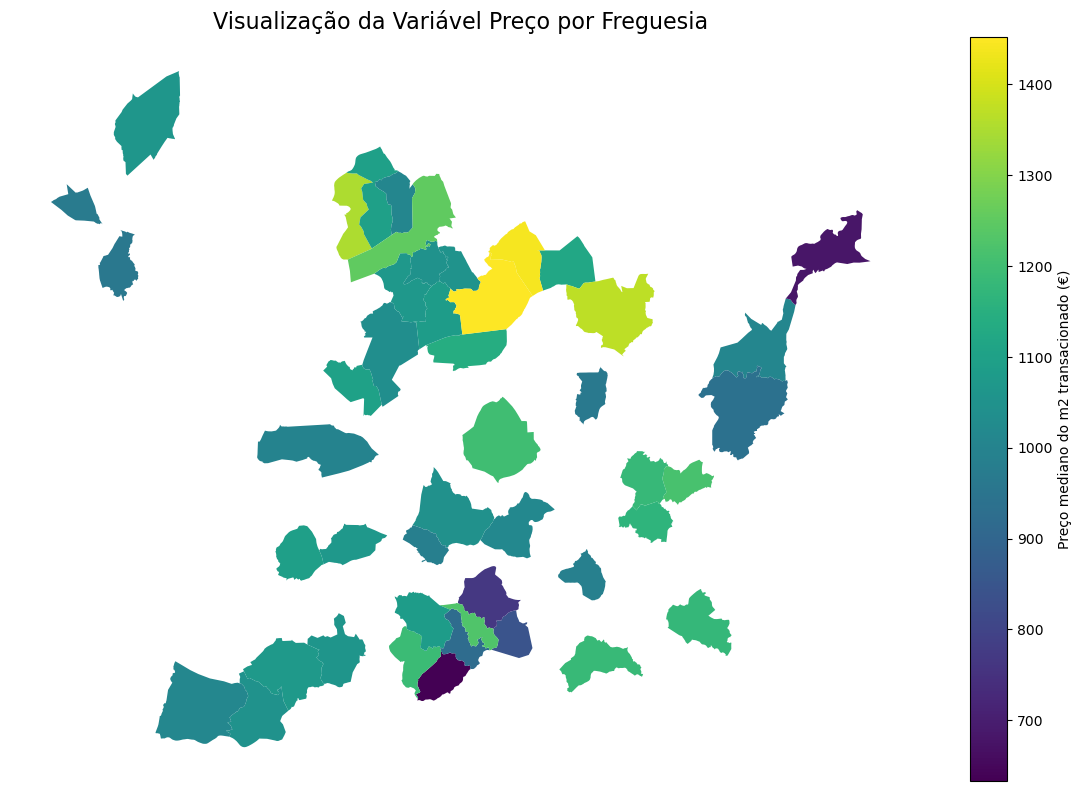

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
# Gerar o mapa baseado na variável 'Preço'
df_shape_com_precos.plot(
    column='Preço',  # Coluna para colorir os polígonos
    cmap='viridis',  # Escolha de esquema de cores (pode ser alterado para outros, como 'plasma', 'coolwarm', etc.)
    legend=True,     # Mostrar a legenda para os valores de 'Preço'
    legend_kwds={
        'label': "Preço mediano do m2 transacionado (€)",
        'orientation': "vertical"
    },
    ax=ax            # Eixo onde o gráfico será desenhado
)
    
# Títulos e personalização
ax.set_title('Visualização da Variável Preço por Freguesia', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_axis_off()  # Oculta os eixos para visualização limpa
    
# Exibir o mapa
plt.tight_layout()
plt.show()

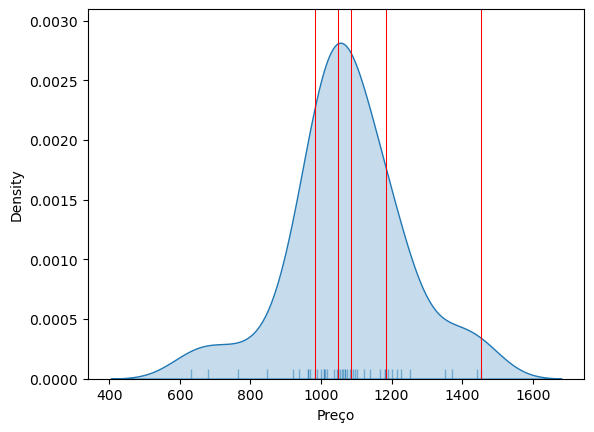

In [10]:
# Visualizar distribuição de densidades para os preços
lista_precos = df_shape_com_precos["Preço"]
lista_precos_sem_nulos = lista_precos[lista_precos > 0]

# Intervalos iguais
classi = mc.EqualInterval(lista_precos_sem_nulos, k=7)
classi

# Quantis
classi_quant = mc.Quantiles(lista_precos_sem_nulos, k=5)
classi_quant

# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(lista_precos_sem_nulos, fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(lista_precos_sem_nulos, alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

## Feature engineering - Variável dependente

Construindo matriz de vizinhanças (contiguidades), analisando a dependência espacial e atribuindo valores às observações sem valores registados

In [11]:
# Criando matriz de contiguidades a partir da Contiguidade Queen
w_queen_shape_CAOP_Freguesias = weights.contiguity.Queen.from_dataframe(df_shape_com_precos)

C:\Users\toto9\AppData\Local\Temp\ipykernel_4444\1634448153.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen_shape_CAOP_Freguesias = weights.contiguity.Queen.from_dataframe(df_shape_com_precos)


Calcular o spatial lag e o índice de Moran para as observações originais, sem imputação de dados

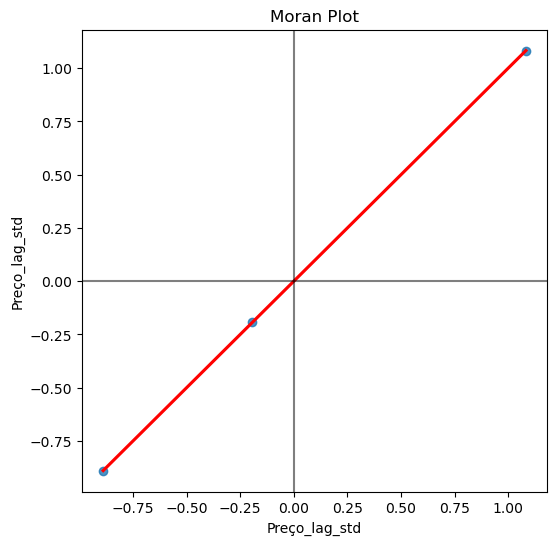

In [12]:
# Compute spatial lag
precoM2_sem_imputacao_lag = weights.lag_spatial(w_queen_shape_CAOP_Freguesias, df_shape_com_precos['Preço'])
df_shape_com_precos["Preço_lag"] = precoM2_sem_imputacao_lag

# "Normalizar" (cálculo de z-scores) as variáveis (original e desfasada)
df_shape_com_precos['Preço_std'] = (df_shape_com_precos['Preço'] - df_shape_com_precos['Preço'].mean() )\
                    / df_shape_com_precos['Preço'].std()
df_shape_com_precos['Preço_lag_std'] = ( df_shape_com_precos['Preço_lag'] - df_shape_com_precos['Preço_lag'].mean() )\
                    / df_shape_com_precos['Preço_lag'].std()

# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Preço_lag_std', y='Preço_lag_std', 
                ci=None, data=df_shape_com_precos, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

In [13]:
moran_HousingTransactionPrice_WQueen = Moran(df_shape_com_precos['Preço'], w_queen_shape_CAOP_Freguesias)
moran_HousingTransactionPrice_WQueen.I, moran_HousingTransactionPrice_WQueen.p_sim

(np.float64(nan), np.float64(0.001))

Imputar os dados para permitir a análise completa

In [14]:
# Imputar preços a partir da matriz de contiguidades
df_shape_com_precos["PreçoInputadoQueen"] = df_shape_com_precos["Preço"].fillna(0)

In [15]:
# Aplicar função definida no início deste Notebook
while (df_shape_com_precos['PreçoInputadoQueen'].isna().sum() > 0) or (df_shape_com_precos['PreçoInputadoQueen'] == 0).sum() > 0:
    df_shape_com_precos.loc[(df_shape_com_precos['PreçoInputadoQueen'] == 0) & (~df_shape_com_precos['PreçoInputadoQueen'].isna()), 'PreçoInputadoQueen'] = \
        df_shape_com_precos.apply(
            lambda row: fill_missing_with_neighborhood_avg(
                row, w=w_queen_shape_CAOP_Freguesias, shape=df_shape_com_precos, colname='PreçoInputadoQueen'
            ) if row['PreçoInputadoQueen'] == 0 else row['PreçoInputadoQueen'], 
            axis=1
        )

df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  Preço_lag_std  PreçoInputadoQueen  
0        NaN            NaN          707.130000  
1        NaN            NaN          627.100380  
2        NaN            NaN          301.885793  
3        NaN            NaN          212.054332  
4        NaN            NaN          312.851730

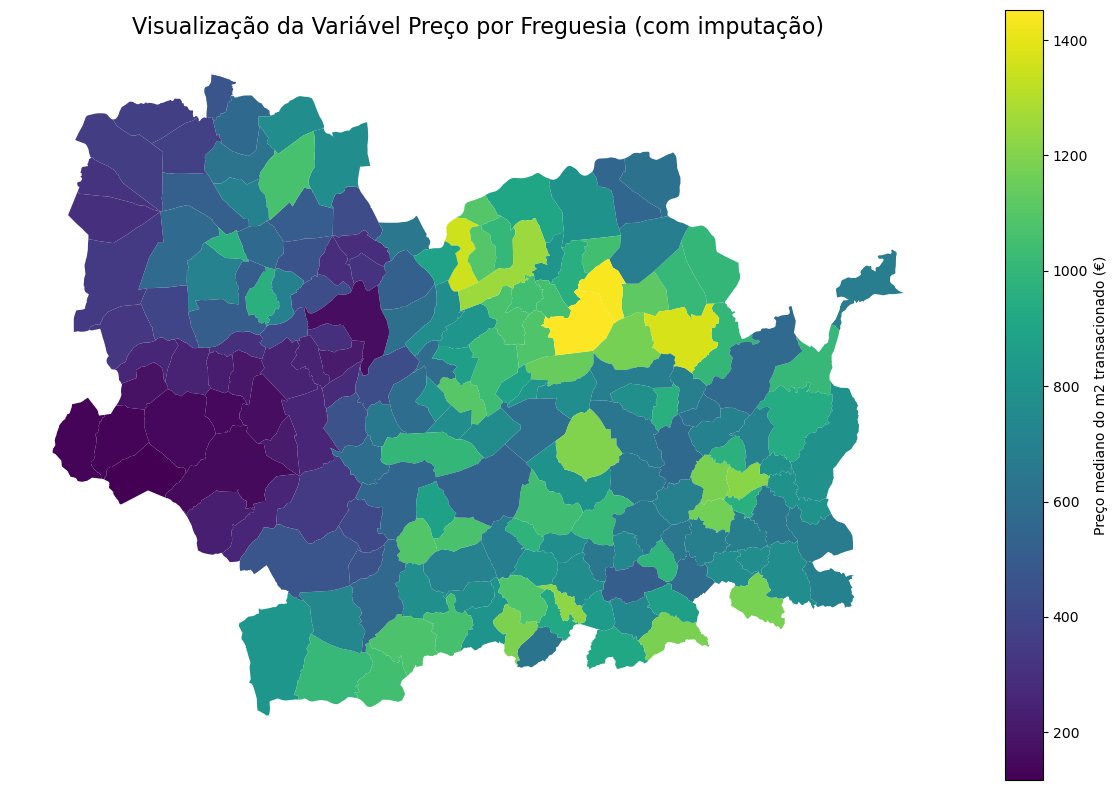

In [16]:
# Visualizar variável preço com valores imputados

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
# Gerar o mapa baseado na variável 'Preço'
df_shape_com_precos.plot(
    column='PreçoInputadoQueen',  # Coluna para colorir os polígonos
    cmap='viridis',  # Escolha de esquema de cores (pode ser alterado para outros, como 'plasma', 'coolwarm', etc.)
    legend=True,     # Mostrar a legenda para os valores de 'Preço'
    legend_kwds={
        'label': "Preço mediano do m2 transacionado (€)",
        'orientation': "vertical"
    },
    ax=ax            # Eixo onde o gráfico será desenhado
)
    
# Títulos e personalização
ax.set_title('Visualização da Variável Preço por Freguesia (com imputação)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_axis_off()  # Oculta os eixos para visualização limpa
    
# Exibir o mapa
plt.tight_layout()
plt.show()

## Dependência espacial da variável-alvo

In [17]:
# Compute spatial lag
precoM2_lag = weights.lag_spatial(w_queen_shape_CAOP_Freguesias, df_shape_com_precos['PreçoInputadoQueen'])
df_shape_com_precos["PreçoInputadoQueen_lag"] = precoM2_lag

# "Normalizar" (cálculo de z-scores) as variáveis (original e desfasada)
df_shape_com_precos['PreçoInputadoQueen_std'] = (df_shape_com_precos['PreçoInputadoQueen'] - df_shape_com_precos['PreçoInputadoQueen'].mean() )\
                    / df_shape_com_precos['PreçoInputadoQueen'].std()
df_shape_com_precos['PreçoInputadoQueen_lag_std'] = ( df_shape_com_precos['PreçoInputadoQueen_lag'] - df_shape_com_precos['PreçoInputadoQueen_lag'].mean() )\
                    / df_shape_com_precos['PreçoInputadoQueen_lag'].std()

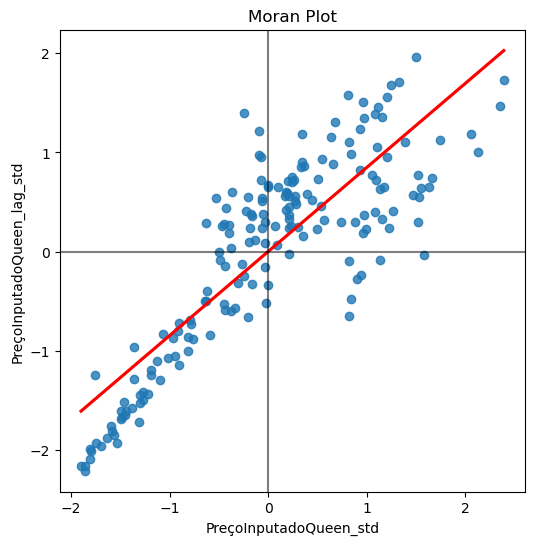

In [18]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='PreçoInputadoQueen_std', y='PreçoInputadoQueen_lag_std', 
                ci=None, data=df_shape_com_precos, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

## Autocorrelação espacial - Global

In [19]:
moran_HousingTransactionPrice_WQueen = Moran(df_shape_com_precos['PreçoInputadoQueen'], w_queen_shape_CAOP_Freguesias)
moran_HousingTransactionPrice_WQueen.I, moran_HousingTransactionPrice_WQueen.p_sim

(np.float64(0.6983902519434381), np.float64(0.001))

## Autocorrelação espacial - Local

In [20]:
# calculate Moran_Local and plot
moranLocal_HousingTransactionPrice_WQueen = Moran_Local(df_shape_com_precos['PreçoInputadoQueen'], w_queen_shape_CAOP_Freguesias)

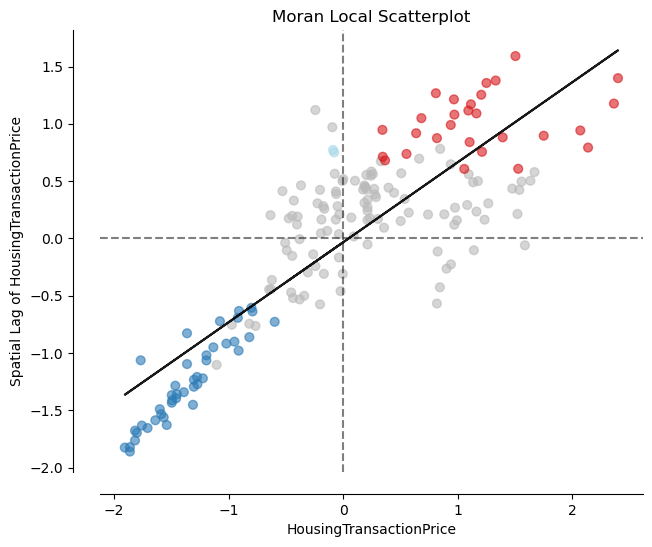

In [21]:
figura, ax = moran_scatterplot(moranLocal_HousingTransactionPrice_WQueen, p=0.05)
ax.set_xlabel('HousingTransactionPrice')
ax.set_ylabel('Spatial Lag of HousingTransactionPrice')
plt.show()

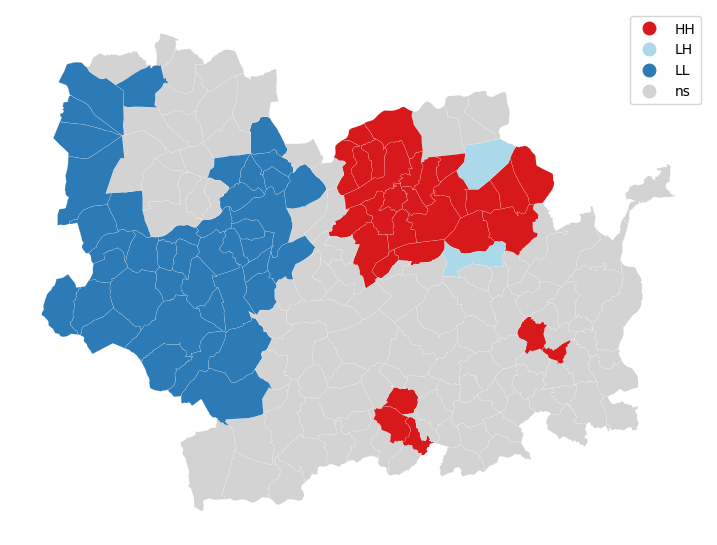

In [22]:
lisa_cluster(moranLocal_HousingTransactionPrice_WQueen, df_shape_com_precos, p=0.05, figsize = (9,9))
plt.show()

In [23]:
precos_freguesia = df_shape_com_precos[["DICOFRE", "Freguesia", "PreçoInputadoQueen"]]
precos_freguesia.head()

DICOFRE       Freguesia  PreçoInputadoQueen
0  030201  Abade de Neiva          707.130000
1  030202          Aborim          627.100380
2  030203           Adães          301.885793
3  030205            Airó          212.054332
4  030206          Aldreu          312.851730

## Feature Engineering - Variáveis Explicativas

Adicionando outras dimensões de informações ao ficheiro original, que contém as freguesias e os preços das habitações. A nossa análise original, feita ao longo do HW01, forneceu-nos indícios da existência de correlação e dependência espacial para a variável dependente (o preço dos imóveis). Isso está de acordo com a teoria vigente, uma vez que uma multitude de fatores que podem explicar as diferenças nos valores dos imóveis apresentam natureza espacial e geográfica: a localização dos imóveis, a tipologia da área, indicadores de desenvolvimento social e económico, etc..

Através de uma análise da literatura, identificamos algumas potenciais variáveis explicativas que poderiam ajudar-nos a enriquecer o modelo explicativo. Realizaremos a seguir a leitura, visualização e incorporação destas variáveis ao Dataframe principal.

In [24]:
# Importar o ficheiro com o COS (perfil de ocupação do solo)
cos_freg = pd.read_csv(r"..\data\cos_freg.csv", sep=";")
cos_freg.head()

COS18n1_L  Espaços descobertos ou com pouca vegetação  \
0              Moure                                         NaN   
1           Cristelo                                         NaN   
2          Carvalhal                                         NaN   
3           Pedralva                                         NaN   
4  Macieira de Rates                                         NaN   

   Territórios artificializados  Pastagens  Florestas  Agricultura    Matos  \
0                       20.2020        NaN    34.5030      45.2911      NaN   
1                       15.1223        NaN    21.2112      63.4588   0.2028   
2                       32.8980        NaN    21.5616      45.5359      NaN   
3                       12.3807     0.0024    49.9701      25.0675  12.5789   
4                       11.1403        NaN    23.4548      65.4011      NaN   

   Massas de água superficiais  Superfícies agroflorestais (SAF) DICOFRE  
0                          NaN                               NaN  030252  
1                          NaN                               NaN  030228  
2                          NaN                               NaN  030220  
3                          NaN                               NaN  030334  
4                          NaN                               NaN  030244

In [25]:
# Criar medida % de território artificializado
cos_freg.fillna(0, inplace=True)
cos_freg["Área total"] = cos_freg["Espaços descobertos ou com pouca vegetação"] + cos_freg["Territórios artificializados"] + cos_freg["Pastagens"] + cos_freg["Florestas"] + cos_freg["Agricultura"] + cos_freg["Matos"] + cos_freg["Massas de água superficiais"] + cos_freg["Superfícies agroflorestais (SAF)"]
cos_freg["Percentual artificializado"] = cos_freg["Territórios artificializados"] / cos_freg["Área total"]
cos_freg.head()

COS18n1_L  Espaços descobertos ou com pouca vegetação  \
0              Moure                                         0.0   
1           Cristelo                                         0.0   
2          Carvalhal                                         0.0   
3           Pedralva                                         0.0   
4  Macieira de Rates                                         0.0   

   Territórios artificializados  Pastagens  Florestas  Agricultura    Matos  \
0                       20.2020     0.0000    34.5030      45.2911   0.0000   
1                       15.1223     0.0000    21.2112      63.4588   0.2028   
2                       32.8980     0.0000    21.5616      45.5359   0.0000   
3                       12.3807     0.0024    49.9701      25.0675  12.5789   
4                       11.1403     0.0000    23.4548      65.4011   0.0000   

   Massas de água superficiais  Superfícies agroflorestais (SAF) DICOFRE  \
0                          0.0                               0.0  030252   
1                          0.0                               0.0  030228   
2                          0.0                               0.0  030220   
3                          0.0                               0.0  030334   
4                          0.0                               0.0  030244   

   Área total  Percentual artificializado  
0     99.9961                    0.202028  
1     99.9951                    0.151230  
2     99.9955                    0.328995  
3     99.9996                    0.123807  
4     99.9962                    0.111407

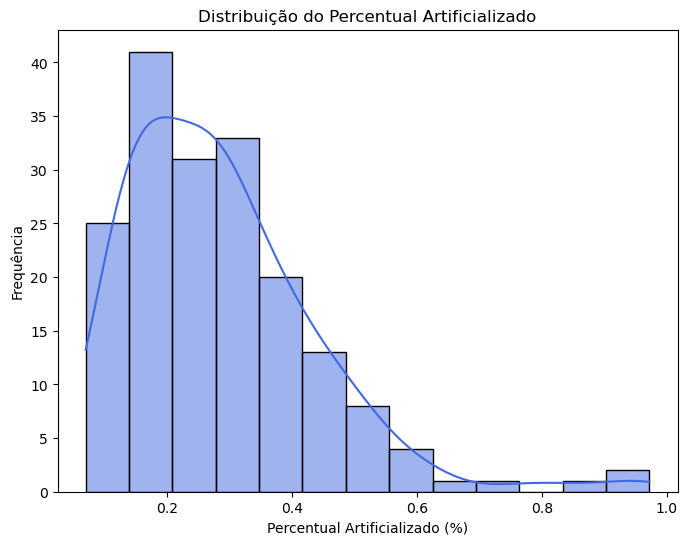

In [26]:
# Visualizar distribuição de densidades de percentual artificializado
bins = int(len(cos_freg["Percentual artificializado"]) ** (1/2))

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(cos_freg["Percentual artificializado"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("Percentual Artificializado (%)")
plt.ylabel("Frequência")
plt.title("Distribuição do Percentual Artificializado")

# Exibir o gráfico
plt.show()

In [27]:
# Importar o ficheiro com o número de fogos licenciados para construção (ampliação da oferta de moradia)
fogos_licenciados = pd.read_csv(r"..\data\Fogos licenciados (N.º) em construções novas para habitação familiar 2021.csv", sep=";")
fogos_licenciados.head()

Freguesia Dicofre  Fogos_licenc
0  Abade de Neiva  030201             5
1          Aborim  030202             0
2           Adães  030203             5
3            Airó  030205            13
4          Aldreu  030206             0

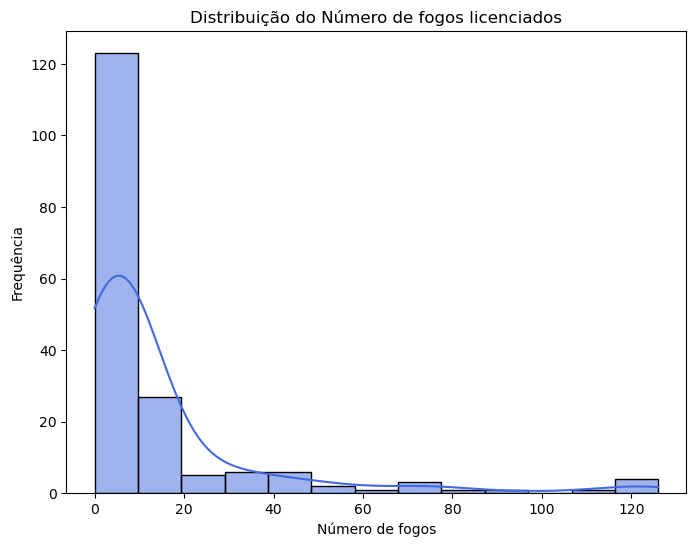

In [28]:
# Visualizar a quantidade de fogos licenciados

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(fogos_licenciados["Fogos_licenc"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("Número de fogos")
plt.ylabel("Frequência")
plt.title("Distribuição do Número de fogos licenciados")

# Exibir o gráfico
plt.show()

In [29]:
# Importar o ficheiro com os índices de envelhecimento da população
ind_envelhecimento = pd.read_csv(r"..\data\Ind_envelhecimento2021.csv", sep=";")
ind_envelhecimento["Ind_envelhecimento"] = pd.to_numeric(ind_envelhecimento["Ind_envelhecimento"].str.replace(",", "."))
ind_envelhecimento.head()

Freguesia Dicofre  Ind_envelhecimento
0  Abade de Neiva  030201              125.90
1          Aborim  030202              165.09
2           Adães  030203              163.64
3            Airó  030205              147.32
4          Aldreu  030206              187.76

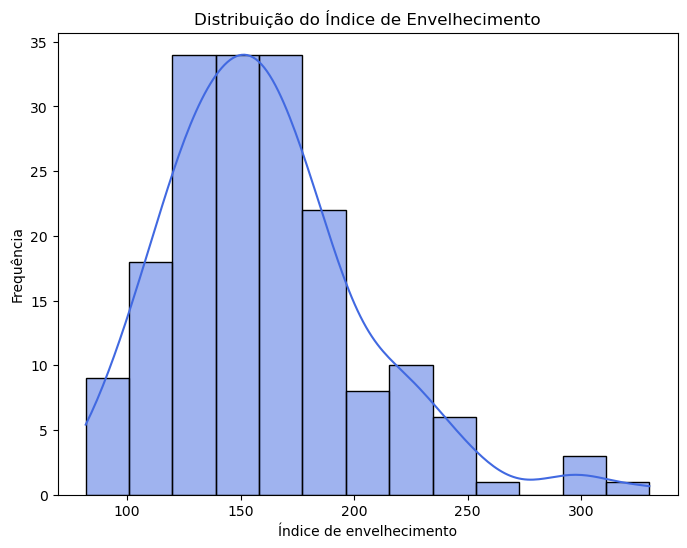

In [30]:
# Visualizar a distribuição dos índices de envelhecimento da população

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(ind_envelhecimento["Ind_envelhecimento"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("Índice de envelhecimento")
plt.ylabel("Frequência")
plt.title("Distribuição do Índice de Envelhecimento")

# Exibir o gráfico
plt.show()

In [31]:
# Importar o ficheiro com a população residente por freguesia
pop_residente = pd.read_csv(r"..\data\População residente (N.º) 2021.csv", sep=";")
pop_residente.rename(columns={"total":"populacao"}, inplace=True)
pop_residente.head()

freguesia dicofre  populacao
0  Abade de Neiva  030201       2009
1          Aborim  030202        827
2           Adães  030203        755
3            Airó  030205        883
4          Aldreu  030206        795

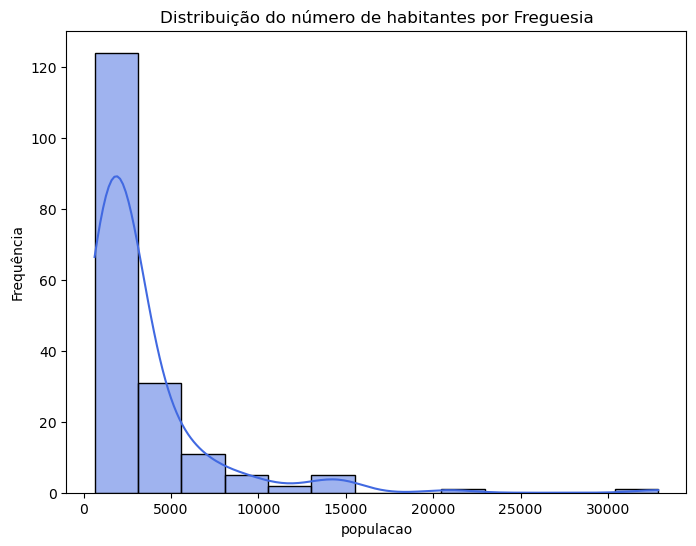

In [32]:
# Visualizar a população por freguesia

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(pop_residente["populacao"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("populacao")
plt.ylabel("Frequência")
plt.title("Distribuição do número de habitantes por Freguesia")

# Exibir o gráfico
plt.show()

In [33]:
# Importar o ficheiro com o rendimento bruto declarado por agregado familiar
rend_por_agregado = pd.read_csv(r"..\data\Rendimento bruto declarado por agregado fiscal (€) por Localização geográfica 2021.csv", sep=";")
rend_por_agregado.drop(columns=["dicofre"], inplace=True)
rend_por_agregado.rename(columns={"dicofre_freg":"dicofre"}, inplace=True)
rend_por_agregado.head()

freguesia  rendimento bruto dicofre
0  Abade de Neiva             21133  030201
1          Aborim             14654  030202
2           Adães             16785  030203
3            Airó             15874  030205
4          Aldreu             15158  030206

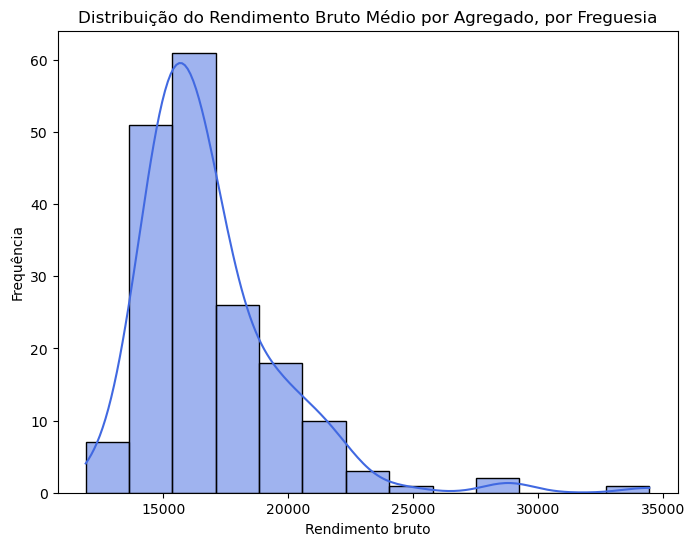

In [34]:
# Visualizar renda por agregado

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(rend_por_agregado["rendimento bruto"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("Rendimento bruto")
plt.ylabel("Frequência")
plt.title("Distribuição do Rendimento Bruto Médio por Agregado, por Freguesia")

# Exibir o gráfico
plt.show()

In [35]:
# Importar o ficheiro com a taxa de desemprego por freguesia
desemprego_por_freguesia = pd.read_csv(r"..\data\taxa_desemprego2021.csv", sep=";")
desemprego_por_freguesia["taxa_desemprego"] = pd.to_numeric(desemprego_por_freguesia["taxa_desemprego"].str.replace(",", "."))
desemprego_por_freguesia.head()

Freguesia Dicofre  taxa_desemprego
0  Abade de Neiva  030201             4.51
1          Aborim  030202             7.25
2           Adães  030203             7.02
3            Airó  030205             4.63
4          Aldreu  030206             5.48

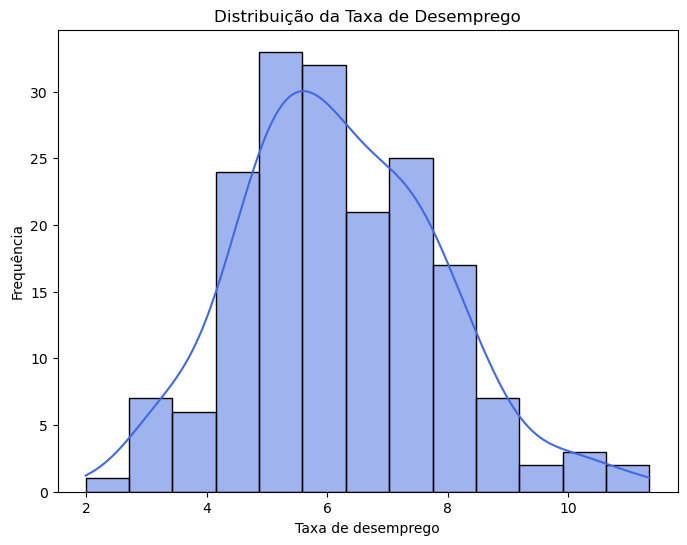

In [36]:
# Visualizar a distribuição dos índices de desemprego por freguesia

# Criar o histograma
plt.figure(figsize=(8, 6))
sns.histplot(desemprego_por_freguesia["taxa_desemprego"], bins=bins, kde=True, color="royalblue")

# Adicionar rótulos e título
plt.xlabel("Taxa de desemprego")
plt.ylabel("Frequência")
plt.title("Distribuição da Taxa de Desemprego")

# Exibir o gráfico
plt.show()

In [37]:
# Importar o ficheiro com o TIPAU por freguesia
tipau_freg = pd.read_csv(r"..\data\TIPAU2014_CavadoAve.csv", sep=";")
tipau_freg.head()

dicofre       freguesia tipau
0  030201  Abade de Neiva   AMU
1  030202          Aborim   AMU
2  030203           Adães   AMU
3  030205            Airó   AMU
4  030206          Aldreu   AMU

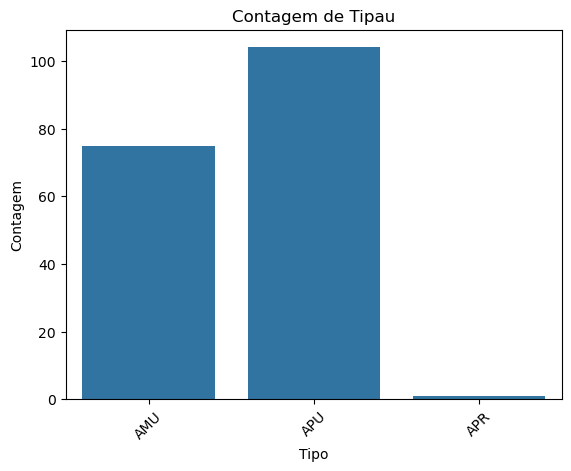

In [38]:
# Criar um barplot para a contagem de tipau em tipau_freg
sns.countplot(data=tipau_freg, x='tipau')
plt.xlabel('Tipo')
plt.ylabel('Contagem')
plt.title('Contagem de Tipau')
plt.xticks(rotation=45)
plt.show()

## Unir novas variáveis à base original

In [39]:
# Verificar base original
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  Preço_lag_std  PreçoInputadoQueen  PreçoInputadoQueen_lag  \
0        NaN            NaN          707.130000              612.084263   
1        NaN            NaN          627.100380              665.138190   
2        NaN            NaN          301.885793              257.781442   
3        NaN            NaN          212.054332              246.009080   
4        NaN            NaN          312.851730              333.207449   

   PreçoInputadoQueen_std  PreçoInputadoQueen_lag_std  
0               -0.002954                   -0.332838  
1               -0.260421                   -0.126082  
2               -1.306681                   -1.713590  
3               -1.595681                   -1.759468  
4               -1.271402                   -1.419648

In [40]:
# Unir com variável "Percentual artificializado"

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    cos_freg[['DICOFRE', 'Percentual artificializado']],
    left_on='DICOFRE',
    right_on='DICOFRE',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  Preço_lag_std  PreçoInputadoQueen  PreçoInputadoQueen_lag  \
0        NaN            NaN          707.130000              612.084263   
1        NaN            NaN          627.100380              665.138190   
2        NaN            NaN          301.885793              257.781442   
3        NaN            NaN          212.054332              246.009080   
4        NaN            NaN          312.851730              333.207449   

   PreçoInputadoQueen_std  PreçoInputadoQueen_lag_std  \
0               -0.002954                   -0.332838   
1               -0.260421                   -0.126082   
2               -1.306681                   -1.713590   
3               -1.595681                   -1.759468   
4               -1.271402                   -1.419648   

   Percentual artificializado  
0                    0.179747  
1                    0.106561  
2                    0.232606  
3                    0.194265  
4                    0.146255

In [41]:
# Unir com variável "Fogos_licenc" do fogos_licenciados

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    fogos_licenciados[['Dicofre', 'Fogos_licenc']],
    left_on='DICOFRE',
    right_on='Dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  Preço_lag_std  PreçoInputadoQueen  PreçoInputadoQueen_lag  \
0        NaN            NaN          707.130000              612.084263   
1        NaN            NaN          627.100380              665.138190   
2        NaN            NaN          301.885793              257.781442   
3        NaN            NaN          212.054332              246.009080   
4        NaN            NaN          312.851730              333.207449   

   PreçoInputadoQueen_std  PreçoInputadoQueen_lag_std  \
0               -0.002954                   -0.332838   
1               -0.260421                   -0.126082   
2               -1.306681                   -1.713590   
3               -1.595681                   -1.759468   
4               -1.271402                   -1.419648   

   Percentual artificializado Dicofre  Fogos_licenc  
0                    0.179747  030201             5  
1                    0.106561  030202             0  
2                    0.232606  030203             5  
3                    0.194265  030205            13  
4                    0.146255  030206             0

In [42]:
# Unir com variável "Ind_envelhecimento" do ind_envelhecimento

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    ind_envelhecimento[['Dicofre', 'Ind_envelhecimento']],
    left_on='DICOFRE',
    right_on='Dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  Preço_lag_std  PreçoInputadoQueen  PreçoInputadoQueen_lag  \
0        NaN            NaN          707.130000              612.084263   
1        NaN            NaN          627.100380              665.138190   
2        NaN            NaN          301.885793              257.781442   
3        NaN            NaN          212.054332              246.009080   
4        NaN            NaN          312.851730              333.207449   

   PreçoInputadoQueen_std  PreçoInputadoQueen_lag_std  \
0               -0.002954                   -0.332838   
1               -0.260421                   -0.126082   
2               -1.306681                   -1.713590   
3               -1.595681                   -1.759468   
4               -1.271402                   -1.419648   

   Percentual artificializado Dicofre_x  Fogos_licenc Dicofre_y  \
0                    0.179747    030201             5    030201   
1                    0.106561    030202             0    030202   
2                    0.232606    030203             5    030203   
3                    0.194265    030205            13    030205   
4                    0.146255    030206             0    030206   

   Ind_envelhecimento  
0              125.90  
1              165.09  
2              163.64  
3              147.32  
4              187.76

In [43]:
# Unir com variável "populacao" do pop_residente

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    pop_residente[['dicofre', "populacao"]],
    left_on='DICOFRE',
    right_on='dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  ...  PreçoInputadoQueen_lag  PreçoInputadoQueen_std  \
0        NaN  ...              612.084263               -0.002954   
1        NaN  ...              665.138190               -0.260421   
2        NaN  ...              257.781442               -1.306681   
3        NaN  ...              246.009080               -1.595681   
4        NaN  ...              333.207449               -1.271402   

   PreçoInputadoQueen_lag_std  Percentual artificializado  Dicofre_x  \
0                   -0.332838                    0.179747     030201   
1                   -0.126082                    0.106561     030202   
2                   -1.713590                    0.232606     030203   
3                   -1.759468                    0.194265     030205   
4                   -1.419648                    0.146255     030206   

   Fogos_licenc Dicofre_y  Ind_envelhecimento dicofre  populacao  
0             5    030201              125.90  030201       2009  
1             0    030202              165.09  030202        827  
2             5    030203              163.64  030203        755  
3            13    030205              147.32  030205        883  
4             0    030206              187.76  030206        795  

[5 rows x 22 columns]

In [44]:
# Unir com variável "rendimento bruto" do rend_por_agregado

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    rend_por_agregado[['dicofre', "rendimento bruto"]],
    left_on='DICOFRE',
    right_on='dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  ...  PreçoInputadoQueen_lag_std  Percentual artificializado  \
0        NaN  ...                   -0.332838                    0.179747   
1        NaN  ...                   -0.126082                    0.106561   
2        NaN  ...                   -1.713590                    0.232606   
3        NaN  ...                   -1.759468                    0.194265   
4        NaN  ...                   -1.419648                    0.146255   

   Dicofre_x  Fogos_licenc  Dicofre_y  Ind_envelhecimento dicofre_x  \
0     030201             5     030201              125.90    030201   
1     030202             0     030202              165.09    030202   
2     030203             5     030203              163.64    030203   
3     030205            13     030205              147.32    030205   
4     030206             0     030206              187.76    030206   

   populacao dicofre_y  rendimento bruto  
0       2009    030201             21133  
1        827    030202             14654  
2        755    030203             16785  
3        883    030205             15874  
4        795    030206             15158  

[5 rows x 24 columns]

In [45]:
# Unir com variável "taxa_desemprego" do desemprego_por_freguesia

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    desemprego_por_freguesia[['Dicofre', "taxa_desemprego"]],
    left_on='DICOFRE',
    right_on='Dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  ...  Dicofre_x  Fogos_licenc  Dicofre_y  Ind_envelhecimento  \
0        NaN  ...     030201             5     030201              125.90   
1        NaN  ...     030202             0     030202              165.09   
2        NaN  ...     030203             5     030203              163.64   
3        NaN  ...     030205            13     030205              147.32   
4        NaN  ...     030206             0     030206              187.76   

   dicofre_x  populacao dicofre_y  rendimento bruto Dicofre  taxa_desemprego  
0     030201       2009    030201             21133  030201             4.51  
1     030202        827    030202             14654  030202             7.25  
2     030203        755    030203             16785  030203             7.02  
3     030205        883    030205             15874  030205             4.63  
4     030206        795    030206             15158  030206             5.48  

[5 rows x 26 columns]

In [46]:
# Unir com variável "tipau" do tipau_freg

# Supondo que ambas as tabelas tenham a coluna "Dicofre"
df_shape_com_precos = df_shape_com_precos.merge(
    tipau_freg[['dicofre', "tipau"]],
    left_on='DICOFRE',
    right_on='dicofre',
    how='left'  # Usa 'left' para manter todas as linhas do df_shape_com_precos
)
df_shape_com_precos.head()

DICOFRE       Freguesia Municipio Distrito  Area_ha      Des_Simpli  \
0  030201  Abade de Neiva  Barcelos    Braga   750.36  Abade de Neiva   
1  030202          Aborim  Barcelos    Braga   618.12          Aborim   
2  030203           Adães  Barcelos    Braga   269.03           Adães   
3  030205            Airó  Barcelos    Braga   302.34            Airó   
4  030206          Aldreu  Barcelos    Braga   479.67          Aldreu   

                                            geometry  Preço  Preço_lag  \
0  MULTIPOLYGON (((-40430.166 210439.124, -40834....    NaN        NaN   
1  MULTIPOLYGON (((-39025.394 216548.1, -39025.75...    NaN        NaN   
2  MULTIPOLYGON (((-34780.474 206117.672, -34785....    NaN        NaN   
3  MULTIPOLYGON (((-34175.486 205104.051, -34189....    NaN        NaN   
4  MULTIPOLYGON (((-45287.179 213175.937, -45288....    NaN        NaN   

   Preço_std  ...  Dicofre_y  Ind_envelhecimento  dicofre_x  populacao  \
0        NaN  ...     030201              125.90     030201       2009   
1        NaN  ...     030202              165.09     030202        827   
2        NaN  ...     030203              163.64     030203        755   
3        NaN  ...     030205              147.32     030205        883   
4        NaN  ...     030206              187.76     030206        795   

   dicofre_y  rendimento bruto Dicofre  taxa_desemprego dicofre  tipau  
0     030201             21133  030201             4.51  030201    AMU  
1     030202             14654  030202             7.25  030202    AMU  
2     030203             16785  030203             7.02  030203    AMU  
3     030205             15874  030205             4.63  030205    AMU  
4     030206             15158  030206             5.48  030206    AMU  

[5 rows x 28 columns]

In [47]:
# Transformar variável categórica "tipau" em dummy através de uma função lambda - agrupamos
df_shape_com_precos["tipau_APU"] = df_shape_com_precos["tipau"].apply(lambda x: 1 if x == "APU" else 0)

In [48]:
# Criar variável "densidade populacional"
df_shape_com_precos["pop_por_area_edificada"] = df_shape_com_precos["populacao"] / (df_shape_com_precos["Area_ha"] * df_shape_com_precos["Percentual artificializado"])

# Excluir colunas dicofre repetidas
df_shape_com_precos.drop(columns=["Dicofre_x", "Dicofre_y", "dicofre_x", "dicofre_y", "Dicofre", "dicofre"], inplace=True)

## Visualizar padrões espaciais das variáveis explicativas adicionadas

In [49]:
# Definir as variáveis
variavel_dependente = "PreçoInputadoQueen"
variaveis_explicativas = ["Percentual artificializado", "Fogos_licenc", "Ind_envelhecimento", "pop_por_area_edificada", "rendimento bruto", "taxa_desemprego", "tipau_APU"]

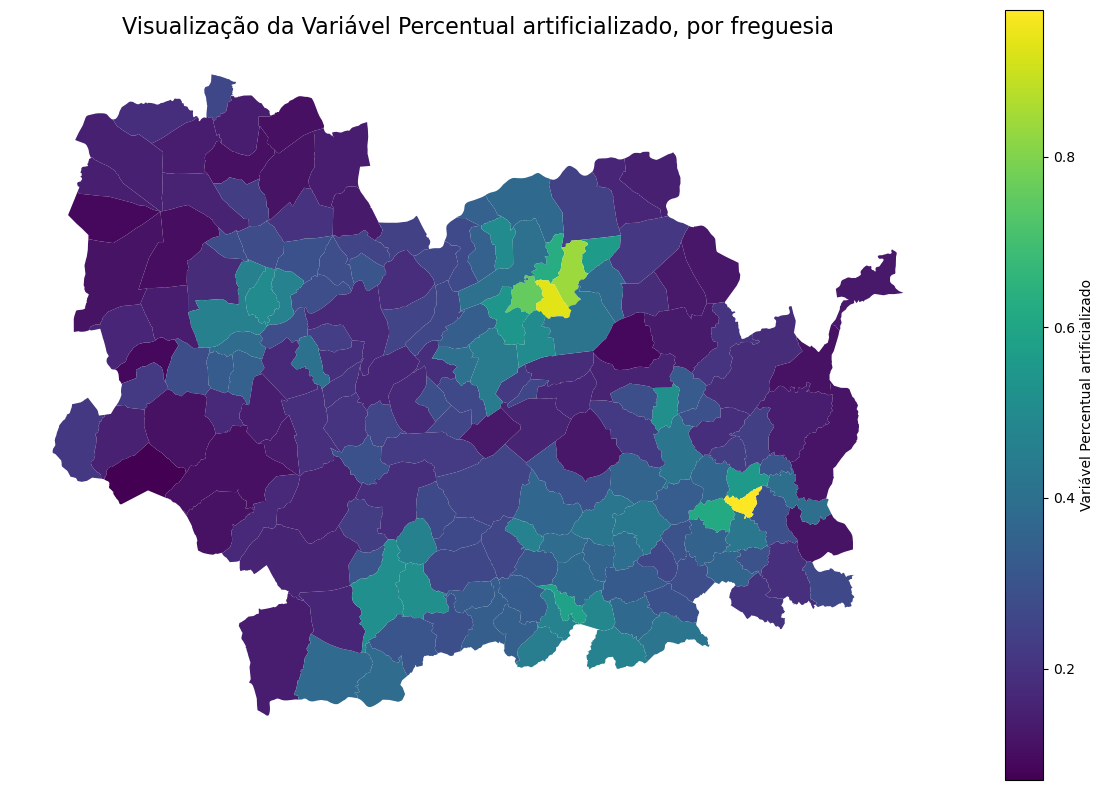

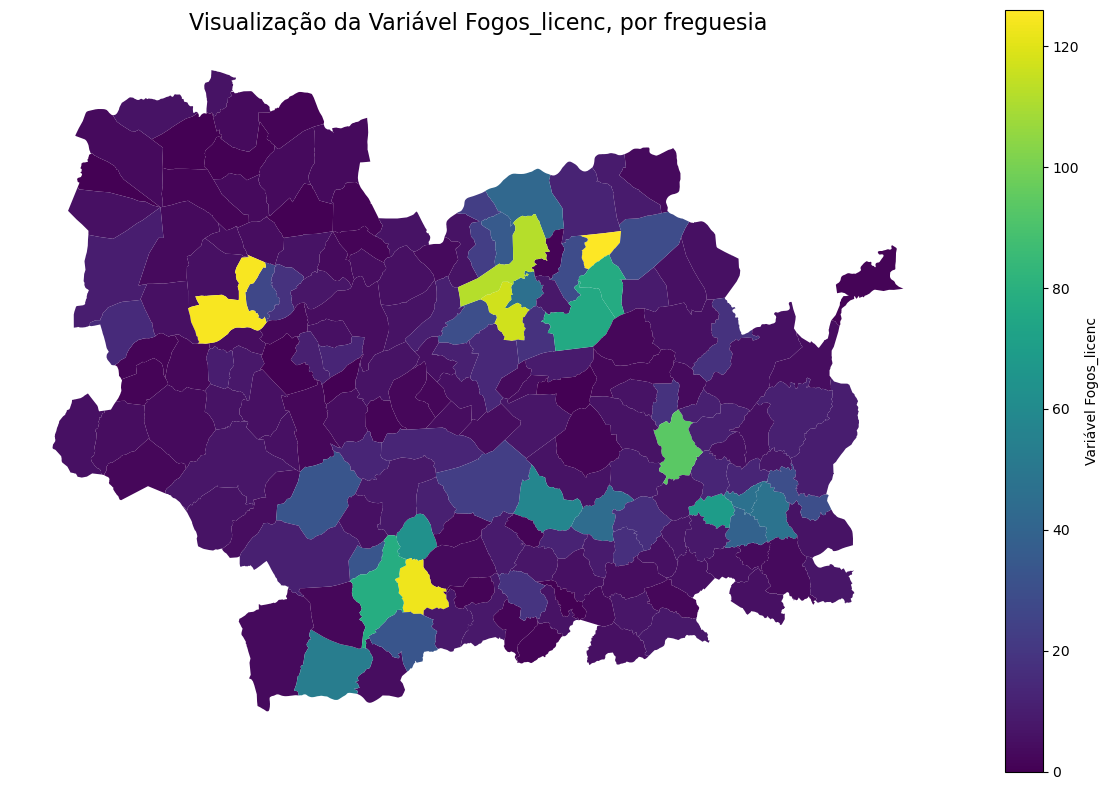

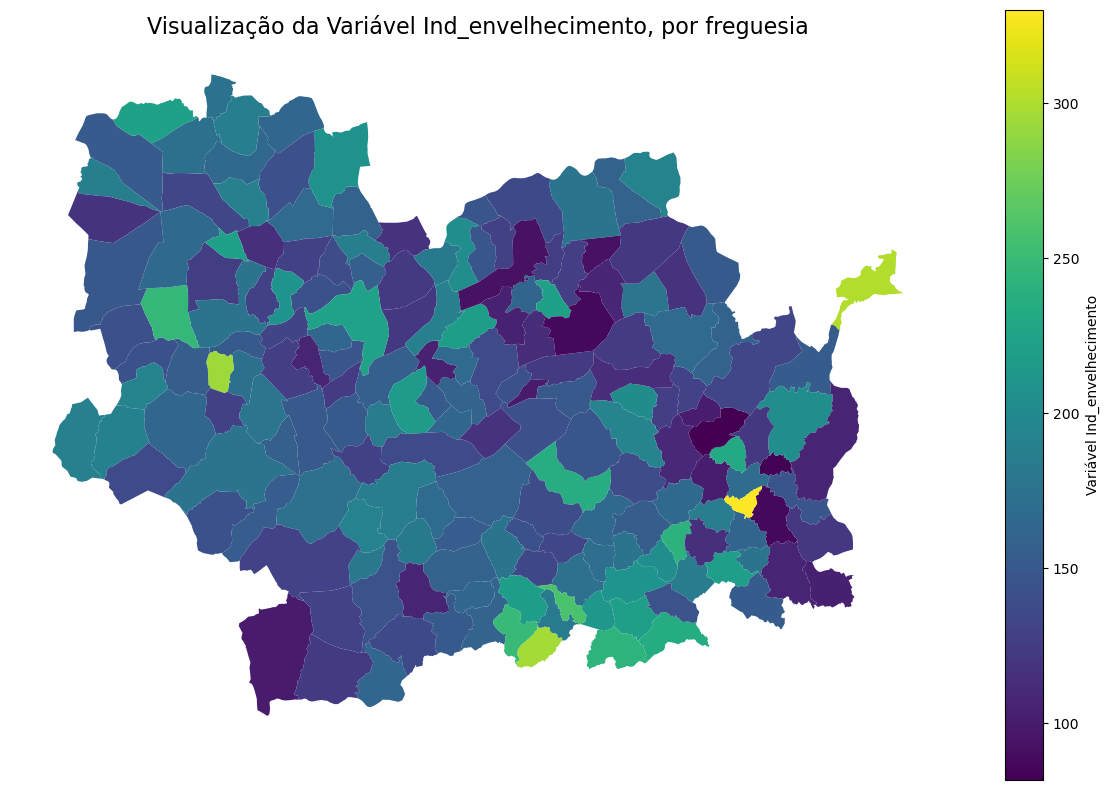

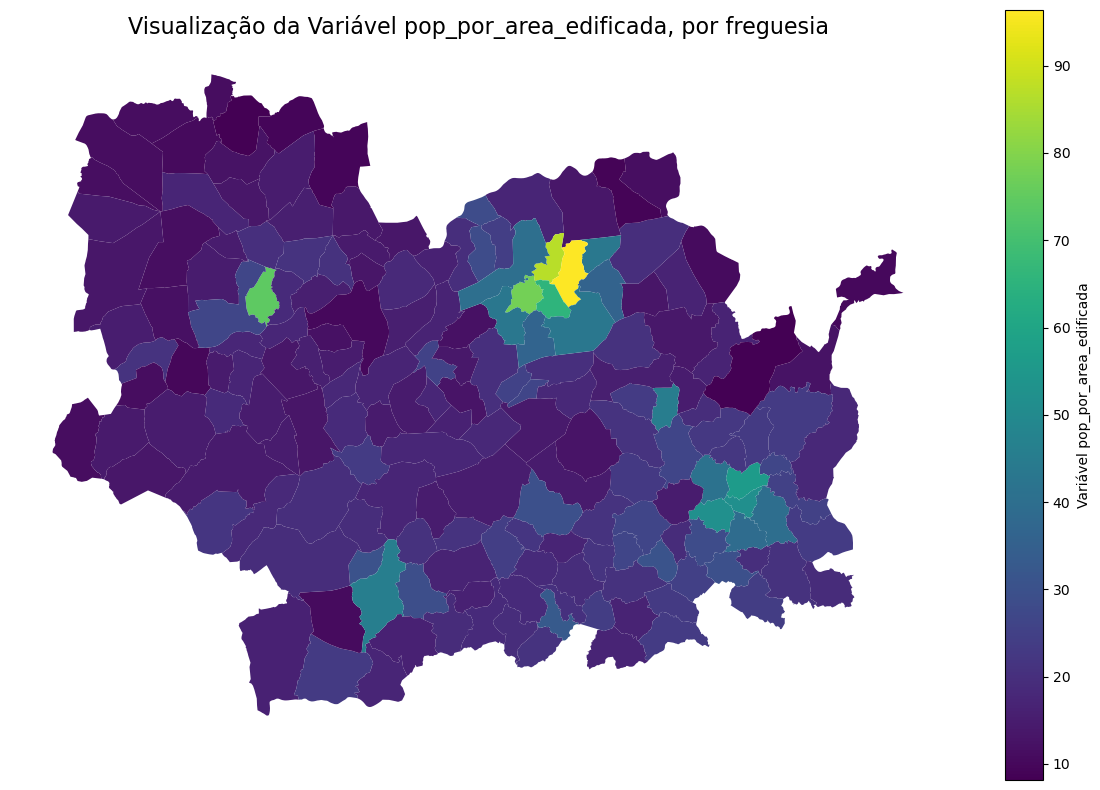

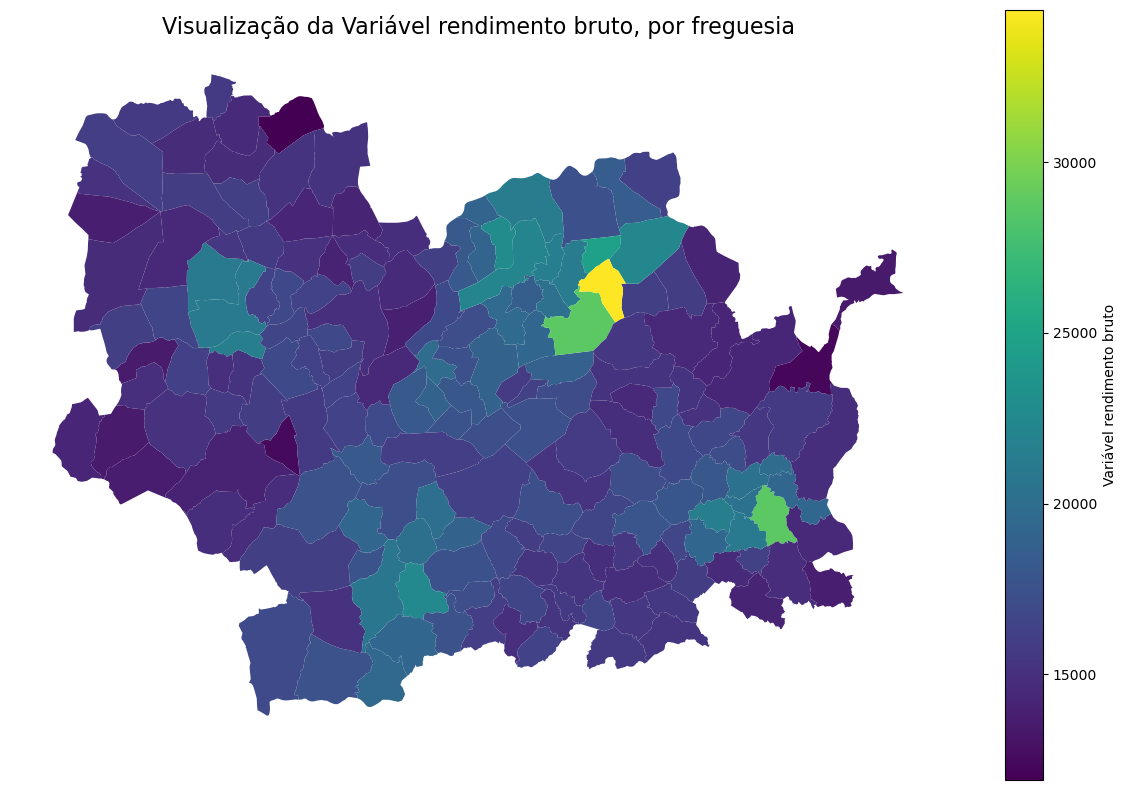

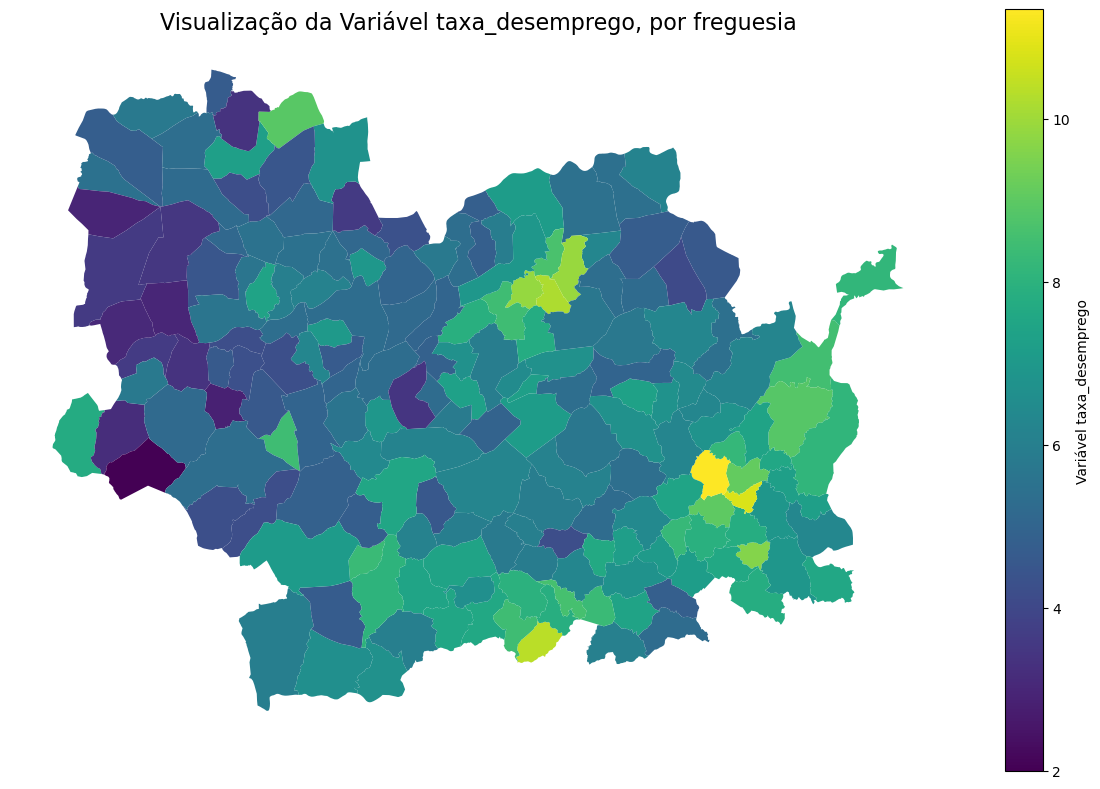

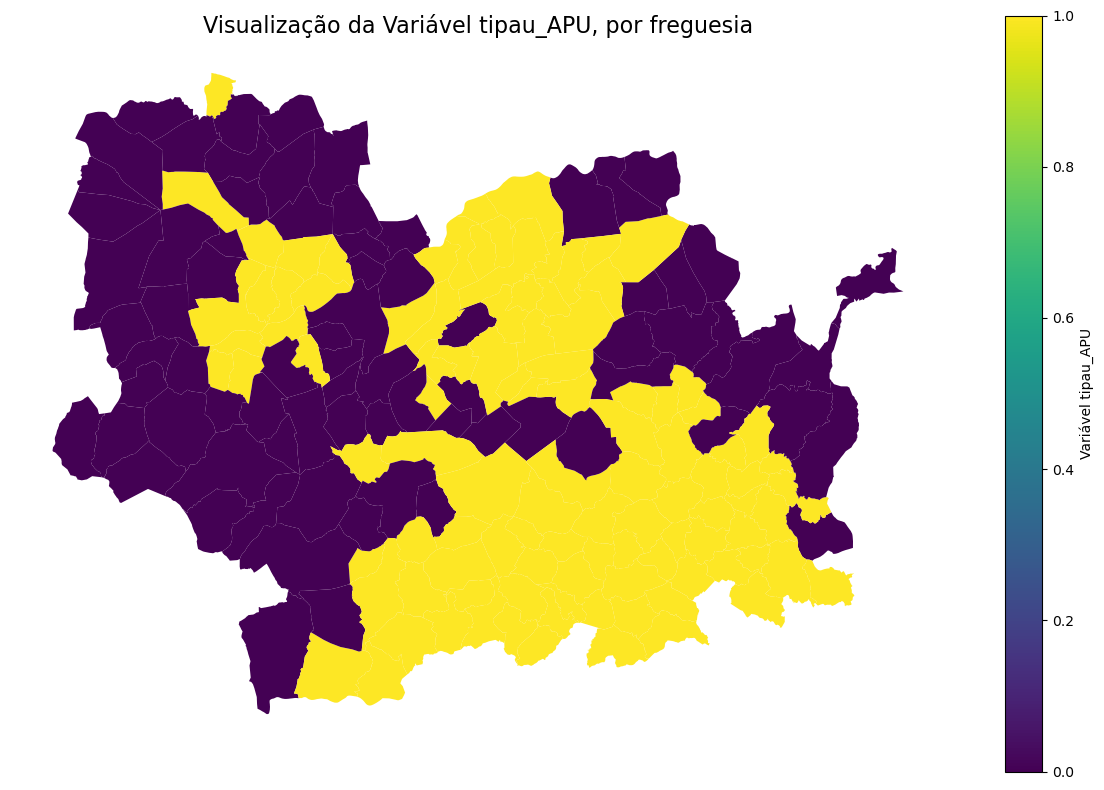

In [50]:
# Visualizar distribuição das variáveis explicativas adicionadas

for i in variaveis_explicativas:
    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
        # Gerar o mapa baseado na variável 'Preço'
        df_shape_com_precos.plot(
            column=i,  # Coluna para colorir os polígonos
            cmap='viridis',  # Escolha de esquema de cores (pode ser alterado para outros, como 'plasma', 'coolwarm', etc.)
            legend=True,     # Mostrar a legenda para os valores de 'Preço'
            legend_kwds={
                'label': "Variável {}".format(i),
                'orientation': "vertical"
            },
            ax=ax            # Eixo onde o gráfico será desenhado
        )
    
        # Títulos e personalização
        ax.set_title('Visualização da Variável {}, por freguesia'.format(i), fontsize=16)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_axis_off()  # Oculta os eixos para visualização limpa
    
        # Exibir o mapa
        plt.tight_layout()
        plt.show()
    except:
        continue

## Dependências espaciais e autocorrelações espaciais para as variáveis explicativas

In [51]:
# Visualização das correlações espaciais para as variáveis independentes

# Autocorrelação espacial - Global
for i in variaveis_explicativas:
    try:
        print("Apresentando dados para a variável {}".format(i))
        moran_HousingTransactionPrice_WQueen = Moran(df_shape_com_precos[i], w_queen_shape_CAOP_Freguesias)
        print("Índice de Moran para a variável {} é {}, com um p-valor de {}".format(i, moran_HousingTransactionPrice_WQueen.I, moran_HousingTransactionPrice_WQueen.p_sim))
    except:
        print("Impossível apresentar dados para a variável {}".format(i))

Apresentando dados para a variável Percentual artificializado
Índice de Moran para a variável Percentual artificializado é 0.5474442167816809, com um p-valor de 0.001
Apresentando dados para a variável Fogos_licenc
Índice de Moran para a variável Fogos_licenc é 0.22961061491133045, com um p-valor de 0.001
Apresentando dados para a variável Ind_envelhecimento
Índice de Moran para a variável Ind_envelhecimento é 0.1289300678006753, com um p-valor de 0.002
Apresentando dados para a variável pop_por_area_edificada
Índice de Moran para a variável pop_por_area_edificada é 0.4917440003391077, com um p-valor de 0.001
Apresentando dados para a variável rendimento bruto
Índice de Moran para a variável rendimento bruto é 0.49096738200790696, com um p-valor de 0.001
Apresentando dados para a variável taxa_desemprego
Índice de Moran para a variável taxa_desemprego é 0.5138031075899121, com um p-valor de 0.001
Apresentando dados para a variável tipau_APU
Índice de Moran para a variável tipau_APU é 0

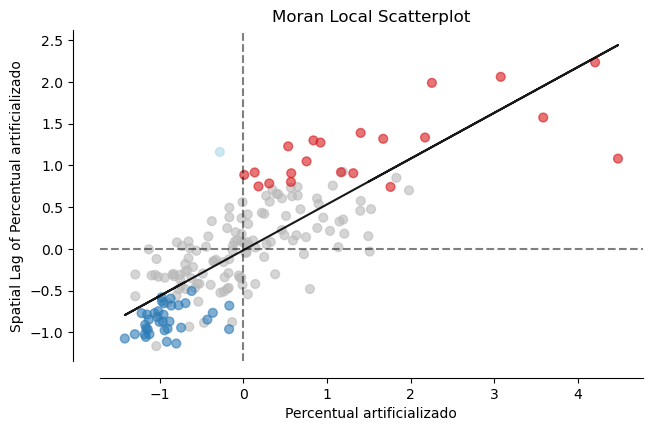

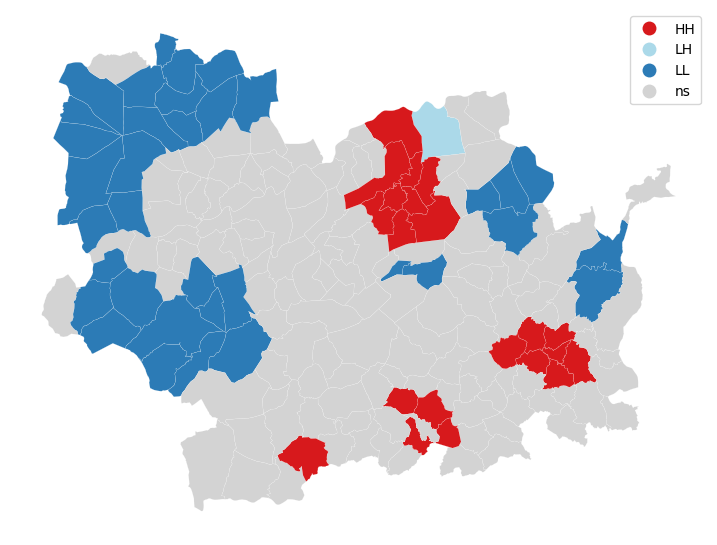

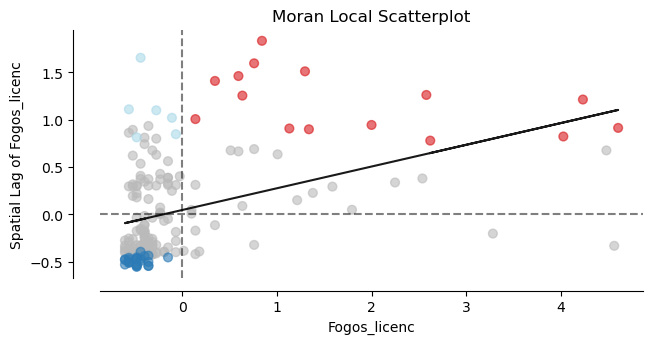

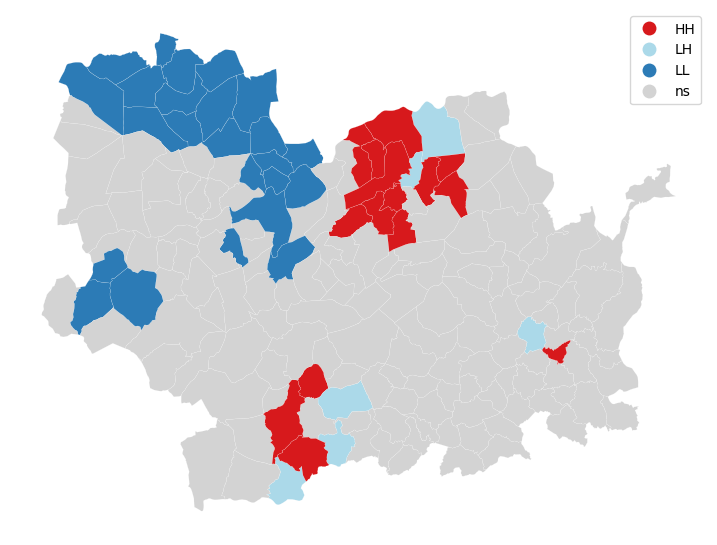

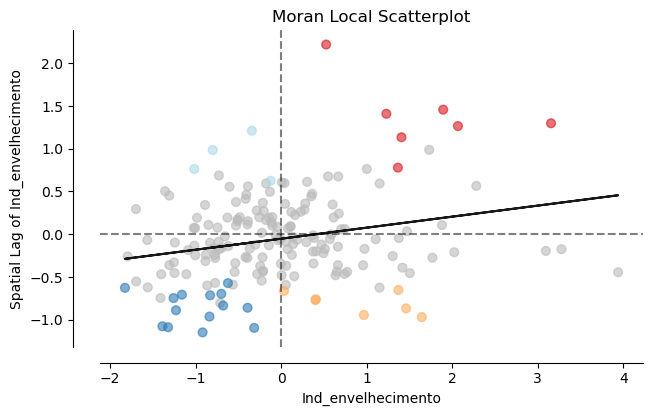

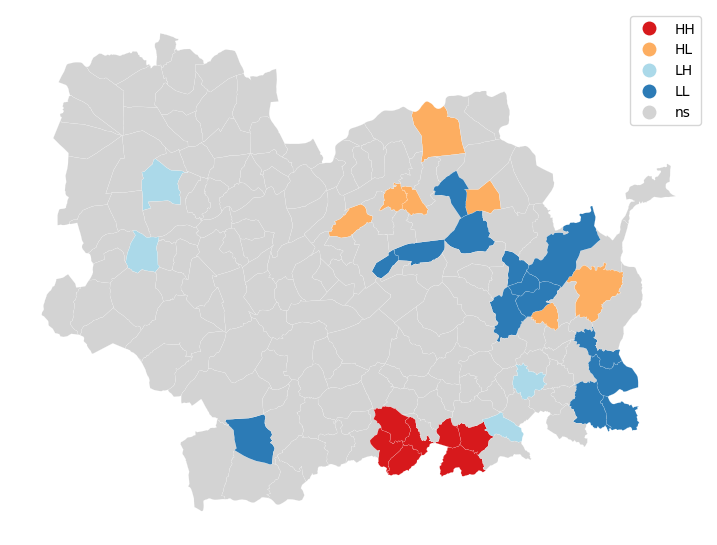

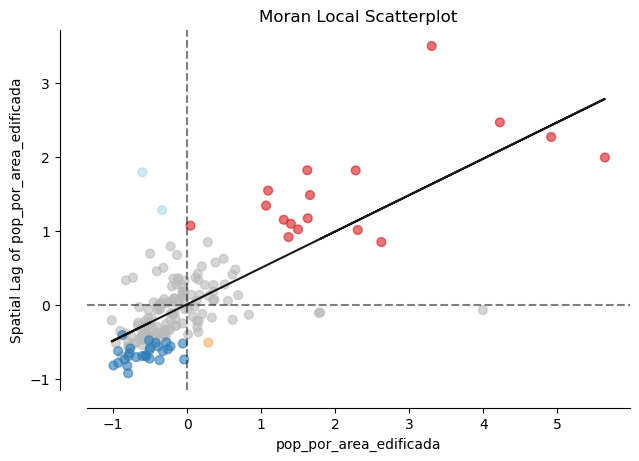

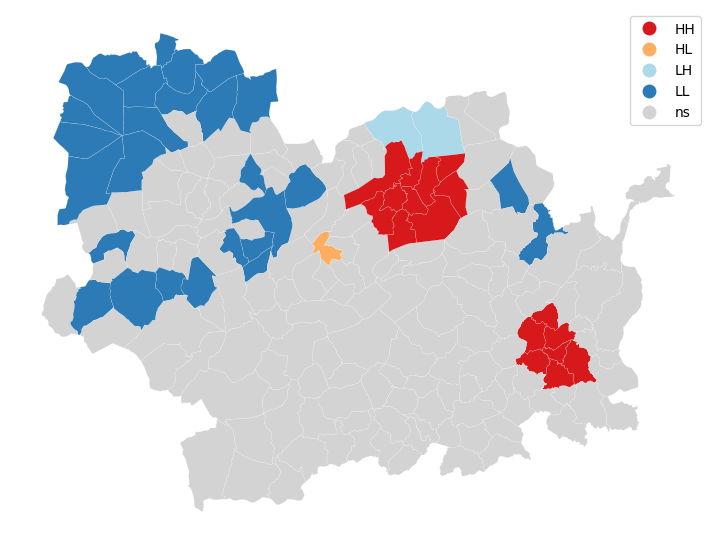

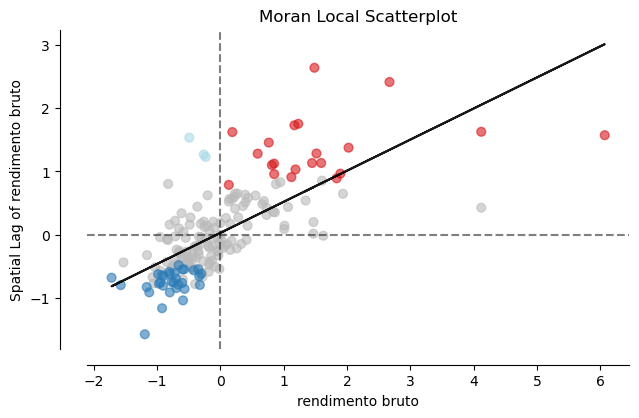

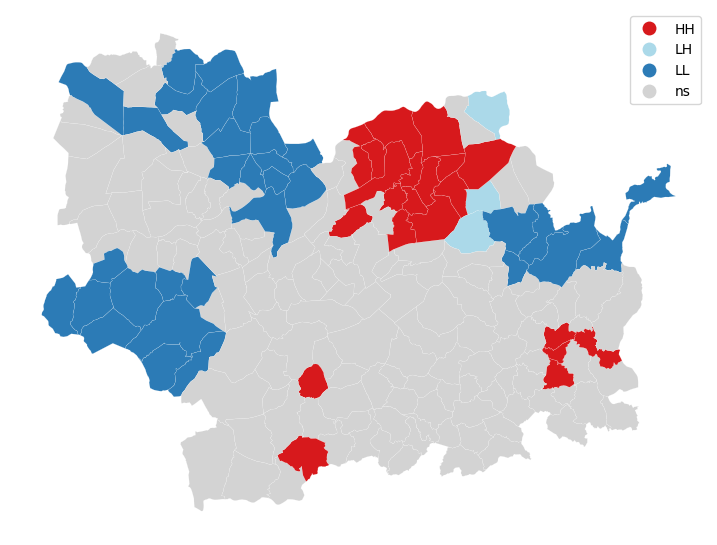

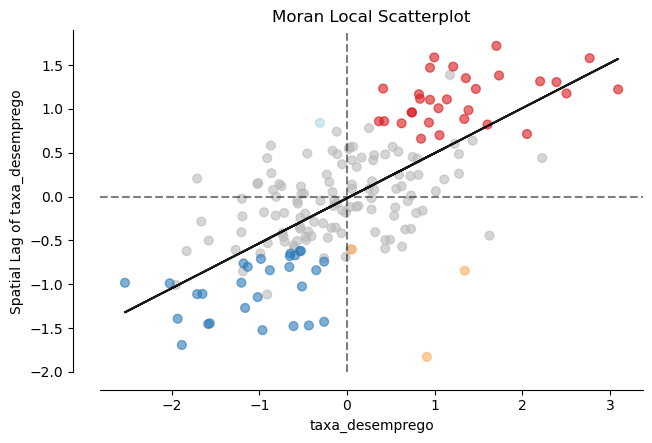

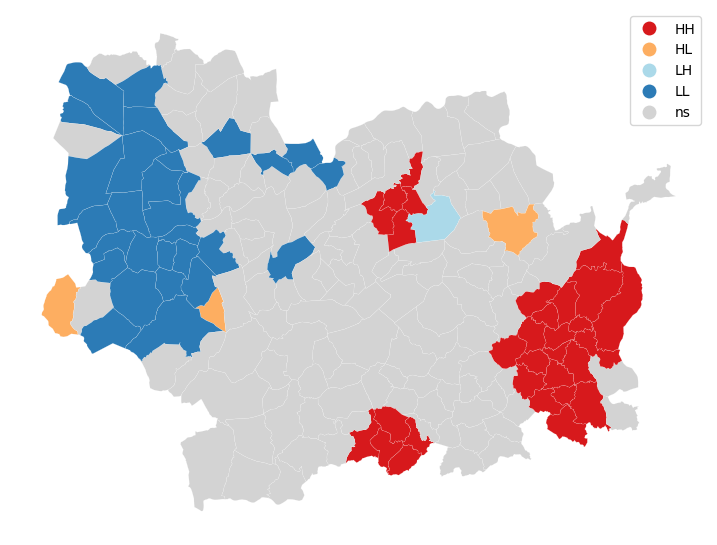

In [52]:
# Autocorrelação espacial - Local
for i in variaveis_explicativas:
    if i in ["tipau_APR", "tipau_APU"]:
        next
    else:
        # calculate Moran_Local and plot
        moranLocal_HousingTransactionPrice_WQueen = Moran_Local(df_shape_com_precos[i], w_queen_shape_CAOP_Freguesias)
        figura, ax = moran_scatterplot(moranLocal_HousingTransactionPrice_WQueen, p=0.05)
        ax.set_xlabel('{}'.format(i))
        ax.set_ylabel('Spatial Lag of {}'.format(i))
        plt.show()

        # Visualizar autocorrelação espacial local no mapa - Lisa
        lisa_cluster(moranLocal_HousingTransactionPrice_WQueen, df_shape_com_precos, p=0.05, figsize = (9,9))
        plt.show()

## Visualizar as relações entre as variáveis explicativas e a variável target (PreçoInputadoQueen)

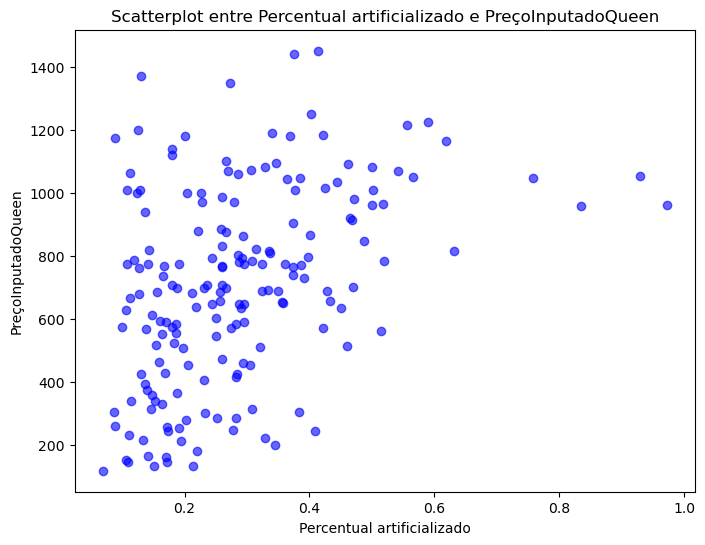

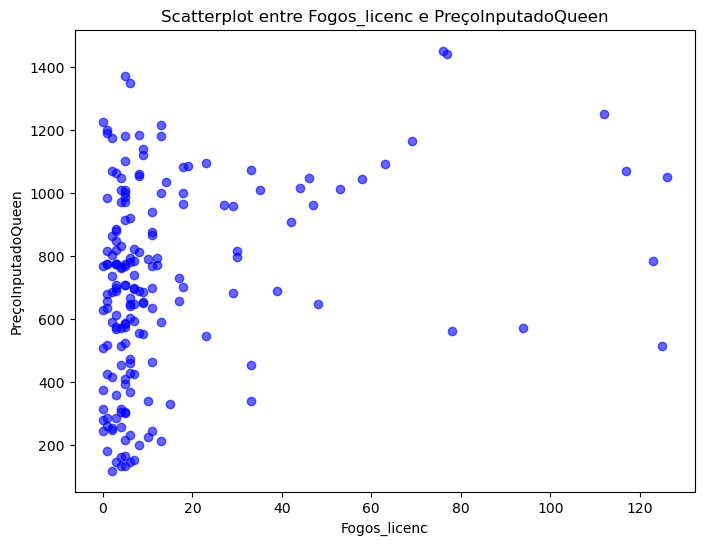

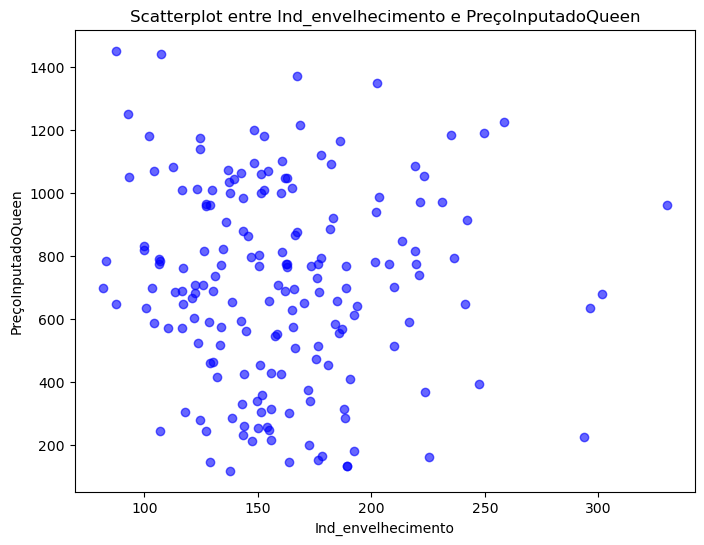

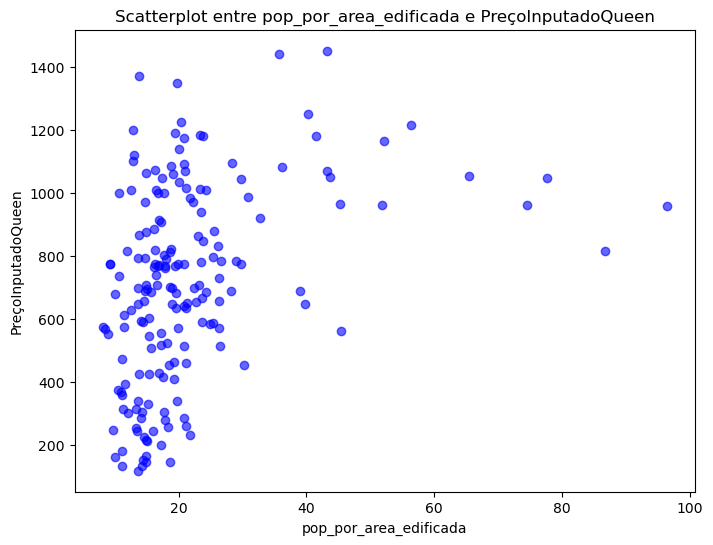

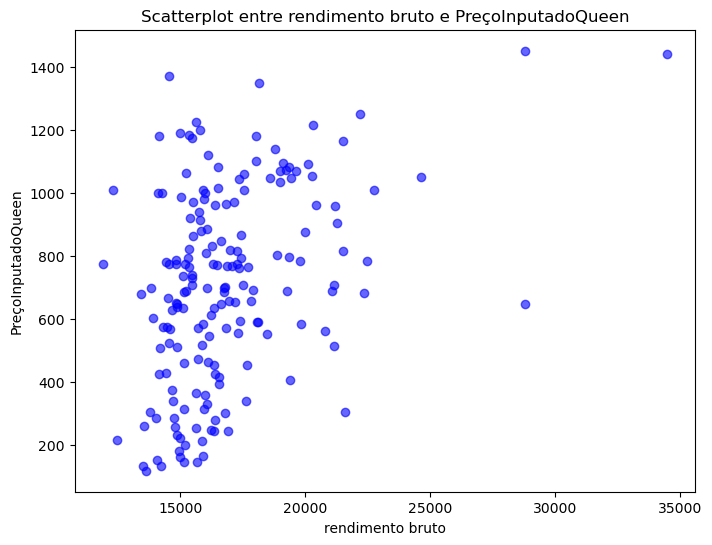

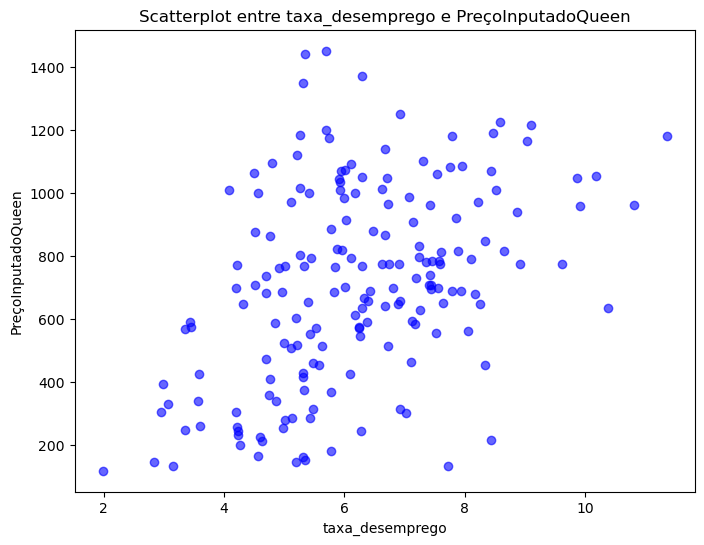

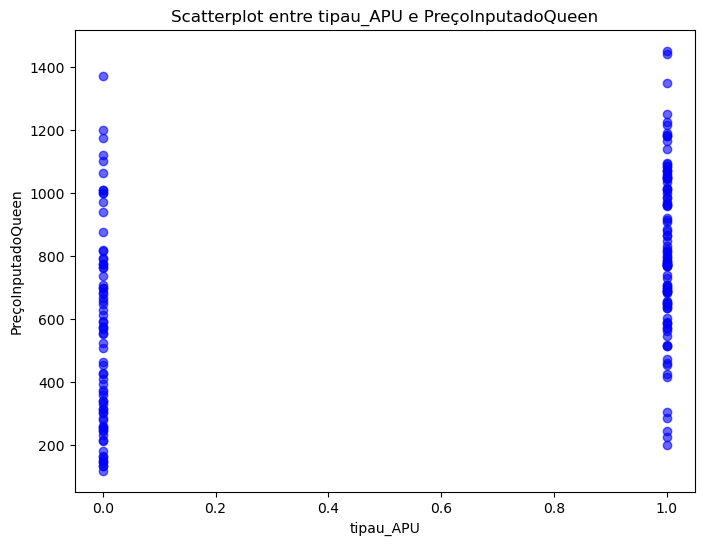

In [72]:
for i in variaveis_explicativas:
    # Gerando o scatterplot
    plt.figure(figsize=(8, 6))  # Tamanho da figura
    plt.scatter(df_shape_com_precos[i], df_shape_com_precos['PreçoInputadoQueen'], color='blue', alpha=0.6)  # Scatter plot
    plt.title('Scatterplot entre {} e PreçoInputadoQueen'.format(i))
    plt.xlabel('{}'.format(i))
    plt.ylabel('PreçoInputadoQueen')

    # Exibindo o gráfico
    plt.show()

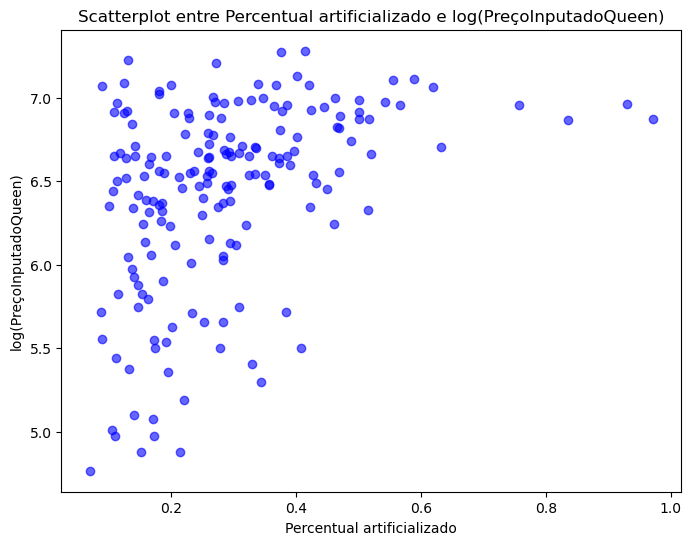

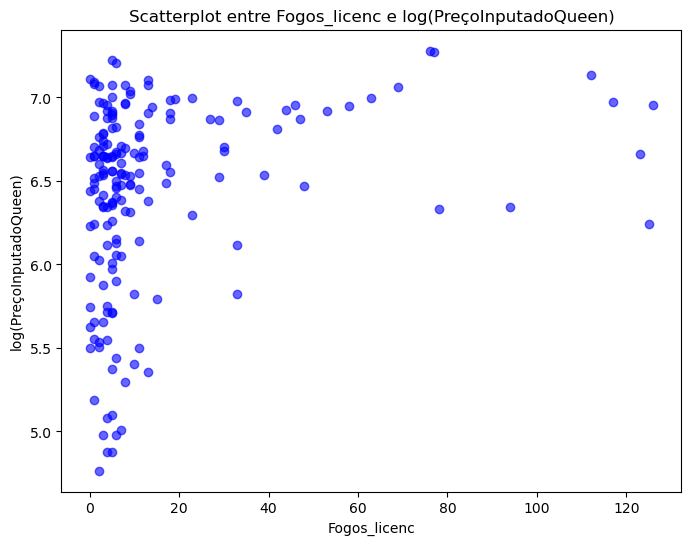

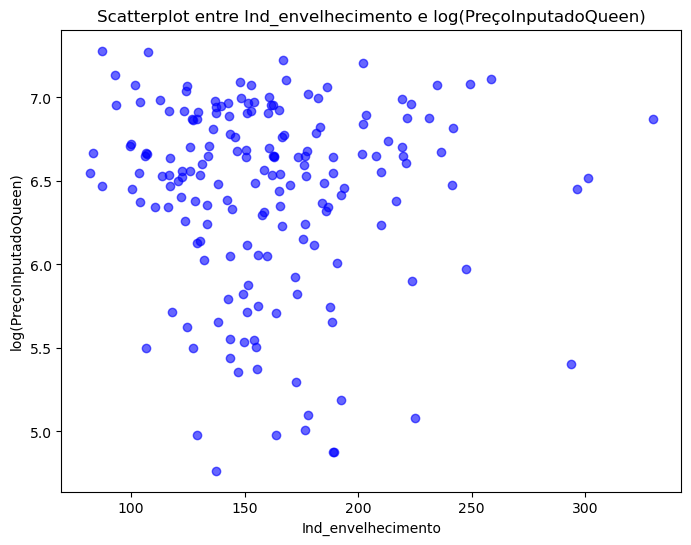

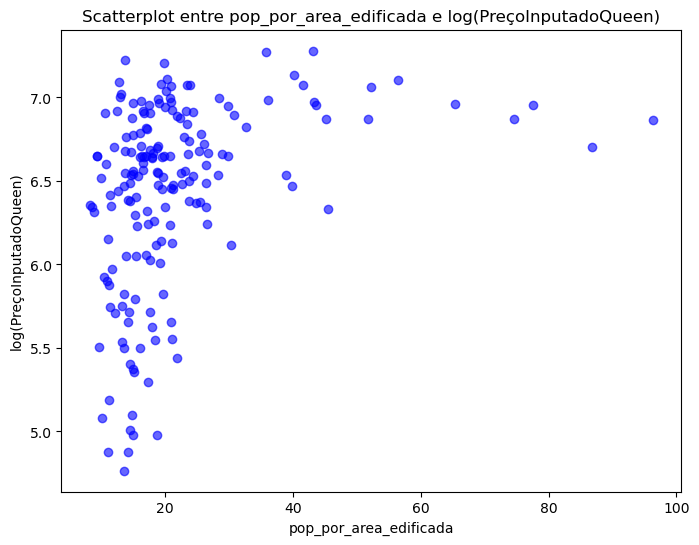

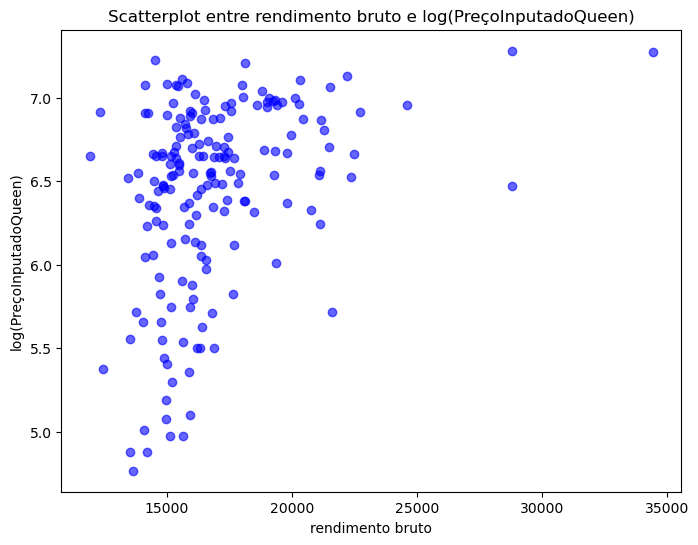

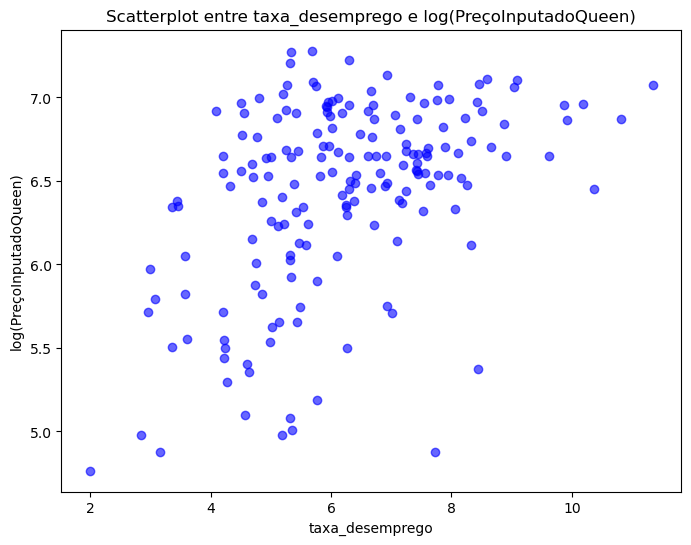

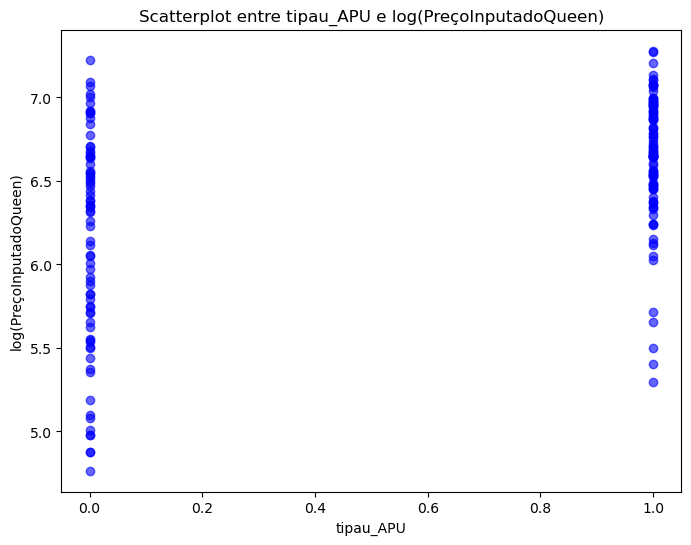

In [75]:
for i in variaveis_explicativas:
    # Gerando o scatterplot
    plt.figure(figsize=(8, 6))  # Tamanho da figura
    plt.scatter(df_shape_com_precos[i], np.log(df_shape_com_precos['PreçoInputadoQueen']), color='blue', alpha=0.6)  # Scatter plot
    plt.title('Scatterplot entre {} e log(PreçoInputadoQueen)'.format(i))
    plt.xlabel('{}'.format(i))
    plt.ylabel('log(PreçoInputadoQueen)')

    # Exibindo o gráfico
    plt.show()

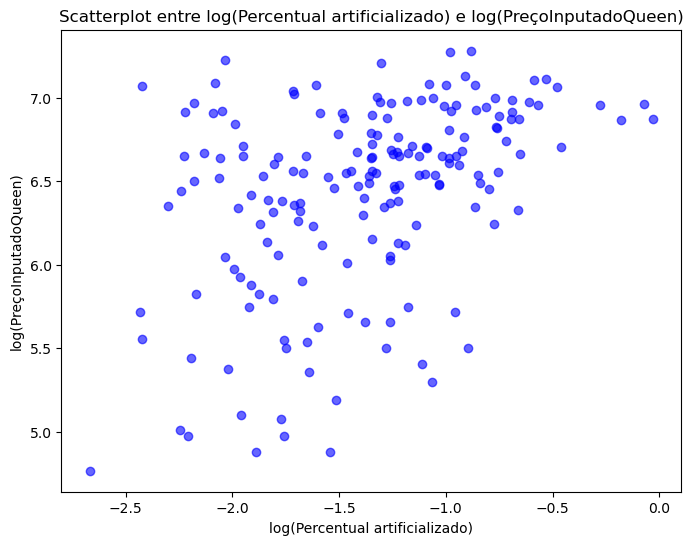

c:\Users\toto9\miniforge3\envs\ETE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


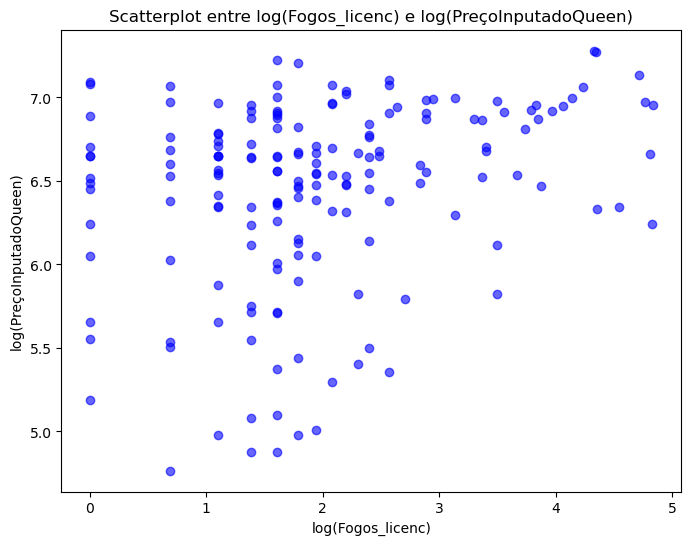

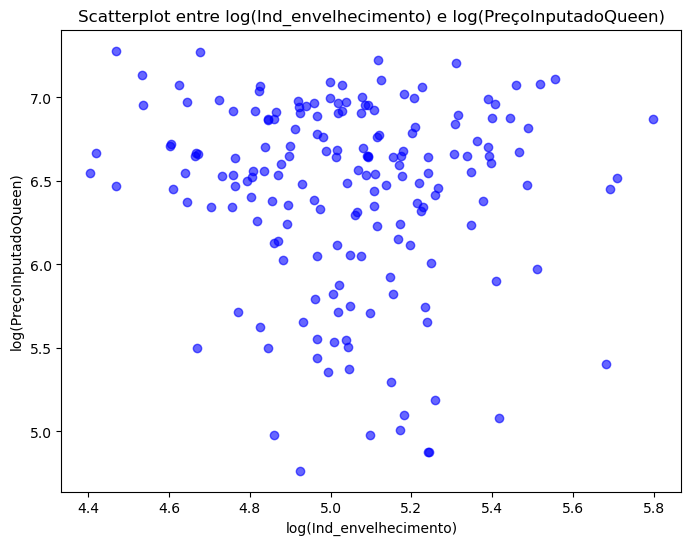

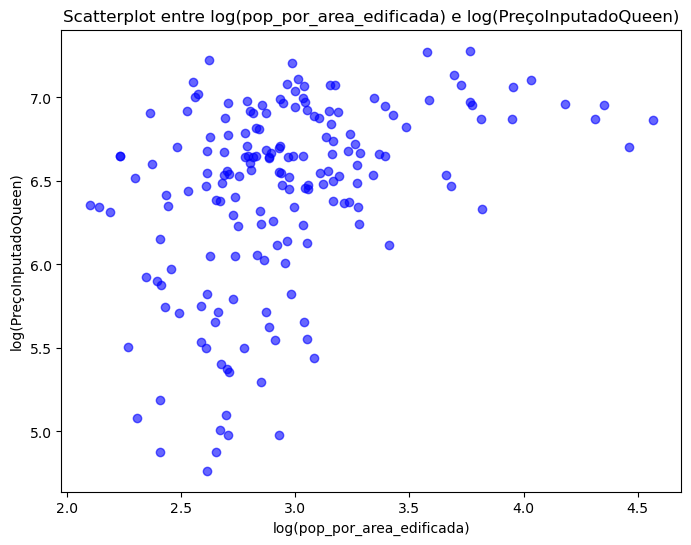

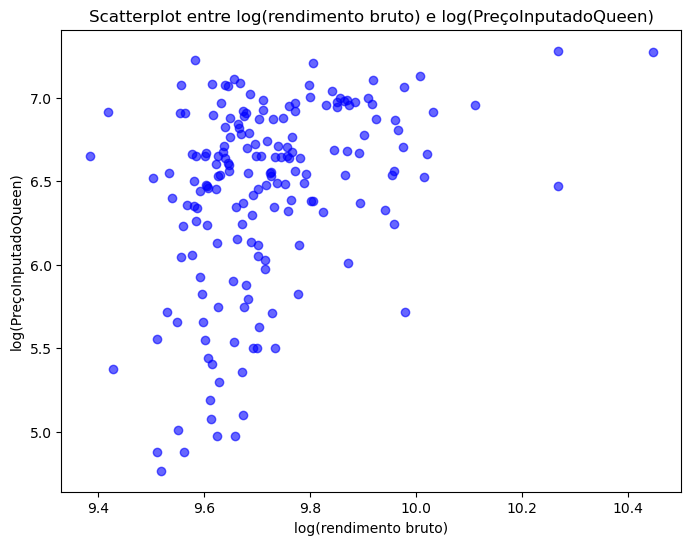

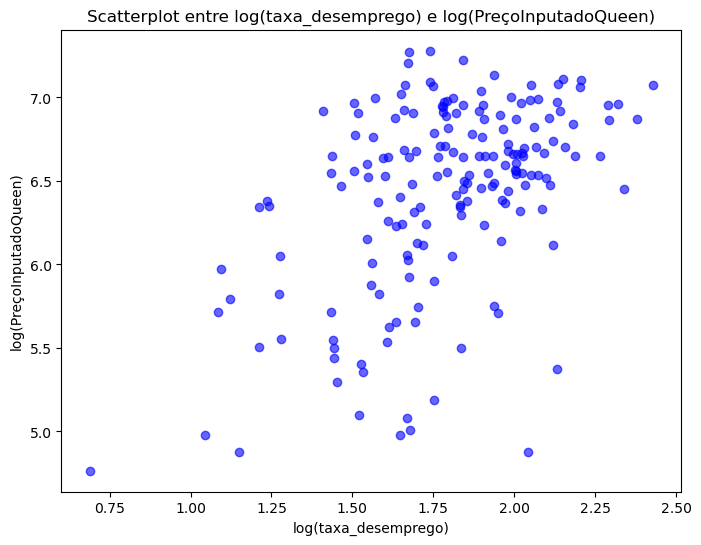

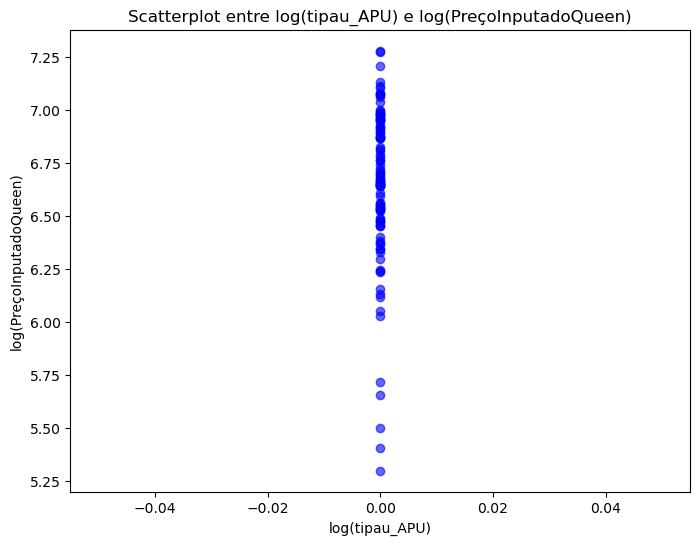

In [76]:
for i in variaveis_explicativas:
    # Gerando o scatterplot
    plt.figure(figsize=(8, 6))  # Tamanho da figura
    plt.scatter(np.log(df_shape_com_precos[i]), np.log(df_shape_com_precos['PreçoInputadoQueen']), color='blue', alpha=0.6)  # Scatter plot
    plt.title('Scatterplot entre log({}) e log(PreçoInputadoQueen)'.format(i))
    plt.xlabel('log({})'.format(i))
    plt.ylabel('log(PreçoInputadoQueen)')

    # Exibindo o gráfico
    plt.show()

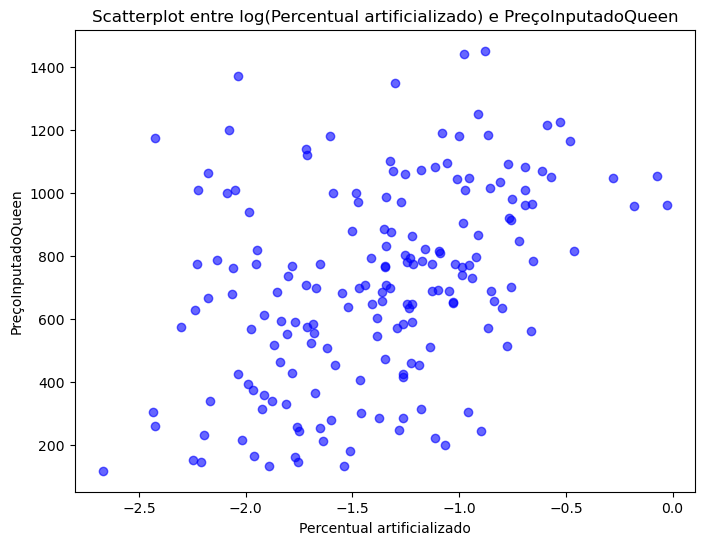

c:\Users\toto9\miniforge3\envs\ETE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


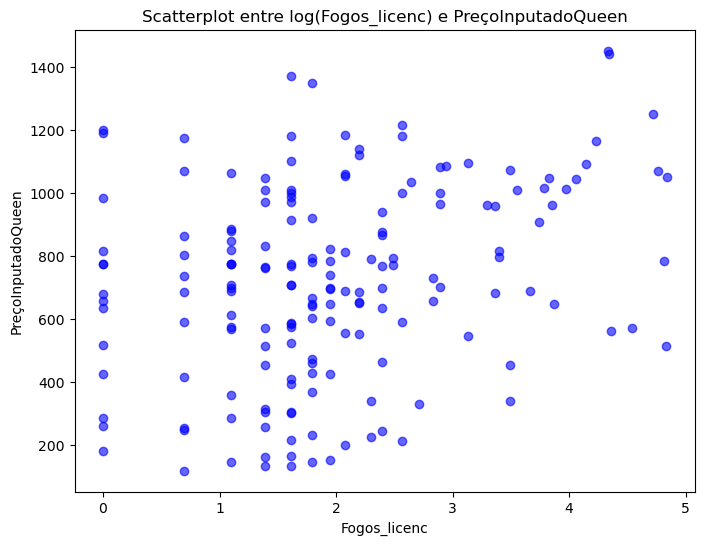

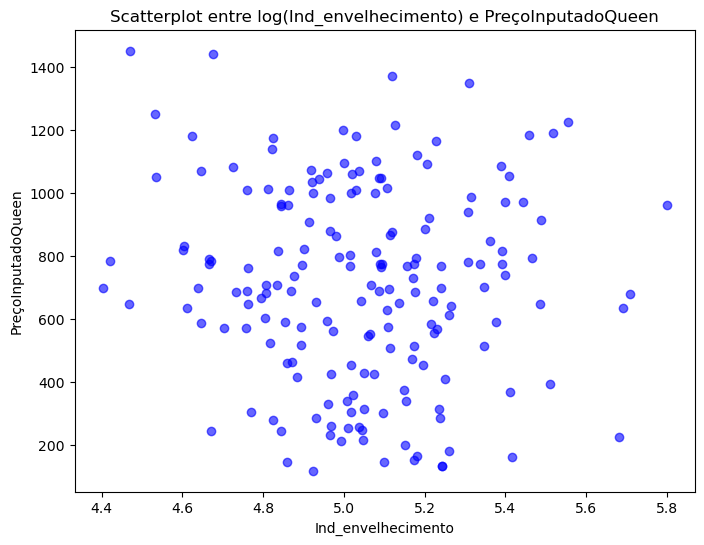

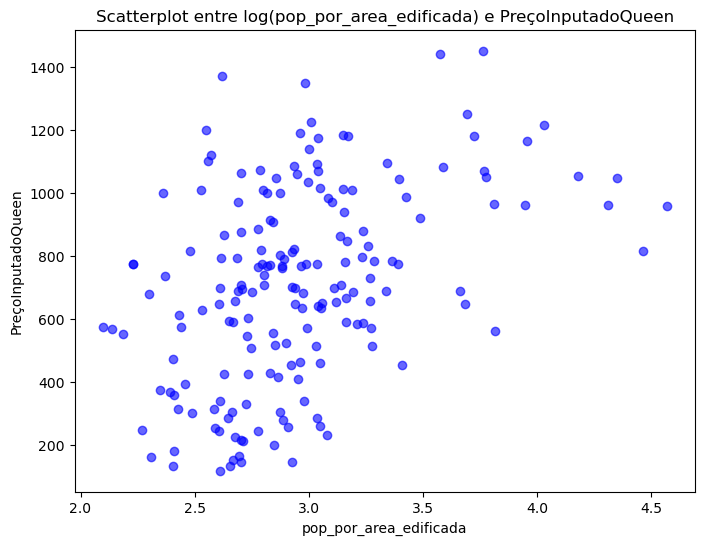

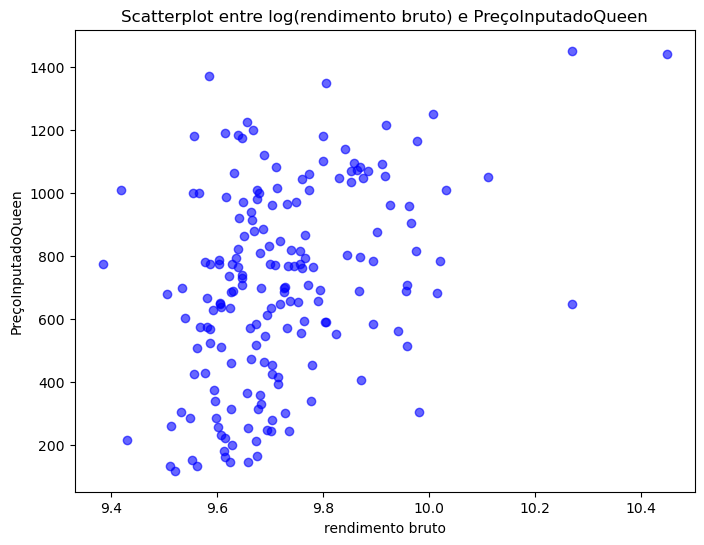

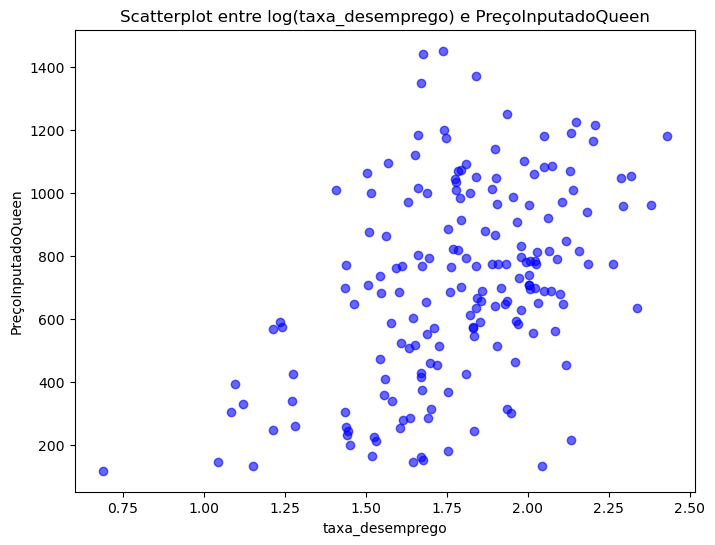

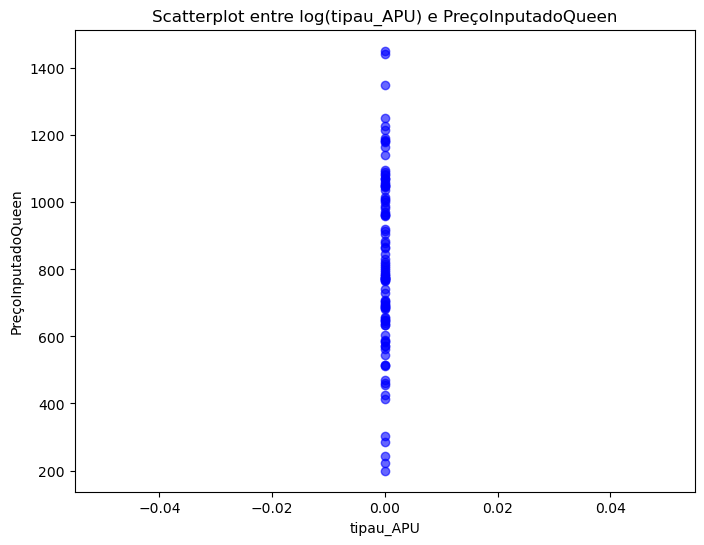

In [77]:
for i in variaveis_explicativas:
    # Gerando o scatterplot
    plt.figure(figsize=(8, 6))  # Tamanho da figura
    plt.scatter(np.log(df_shape_com_precos[i]), df_shape_com_precos['PreçoInputadoQueen'], color='blue', alpha=0.6)  # Scatter plot
    plt.title('Scatterplot entre log({}) e PreçoInputadoQueen'.format(i))
    plt.xlabel('{}'.format(i))
    plt.ylabel('PreçoInputadoQueen')

    # Exibindo o gráfico
    plt.show()

## Modelos Econométricos

In [53]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

### Modelo base - não-espacial

In [54]:
# As variáveis explicativas (variaveis_explicativas) e a variável target, ou dependente (variavel_dependente) já foram selecionadas acima
df_X_modelo_nao_espacial = df_shape_com_precos[variaveis_explicativas]
df_y_modelo_nao_espacial = df_shape_com_precos[variavel_dependente]

# Adicionar constante ao modelo
df_X_modelo_nao_espacial = sm.add_constant(df_X_modelo_nao_espacial)

# Rodar a regressão
modelo_nao_espacial = OLS(
    df_y_modelo_nao_espacial.astype(float), 
    df_X_modelo_nao_espacial.astype(float)
)

results = modelo_nao_espacial.fit()

# Visualizar resultados com os nomes das variáveis
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:     PreçoInputadoQueen   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     11.40
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           7.52e-12
Time:                        10:55:47   Log-Likelihood:                -1253.7
No. Observations:                 180   AIC:                             2523.
Df Residuals:                     172   BIC:                             2549.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Figure size 800x600 with 0 Axes>

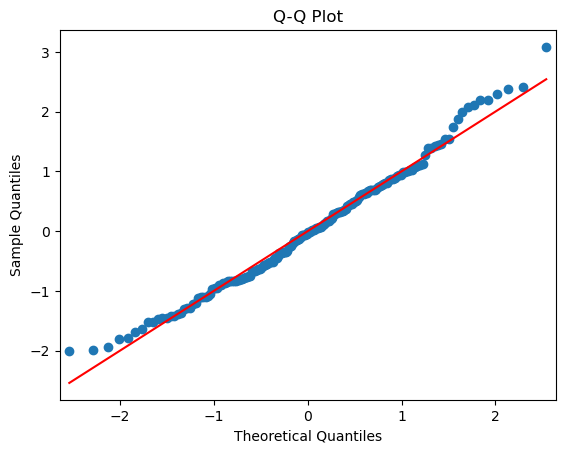

In [55]:
# Avaliando a validade

# Q-Q plot
plt.figure(figsize=(8,6))
sm.qqplot(results.resid, line ='s', fit=True)
plt.title('Q-Q Plot')
plt.show()

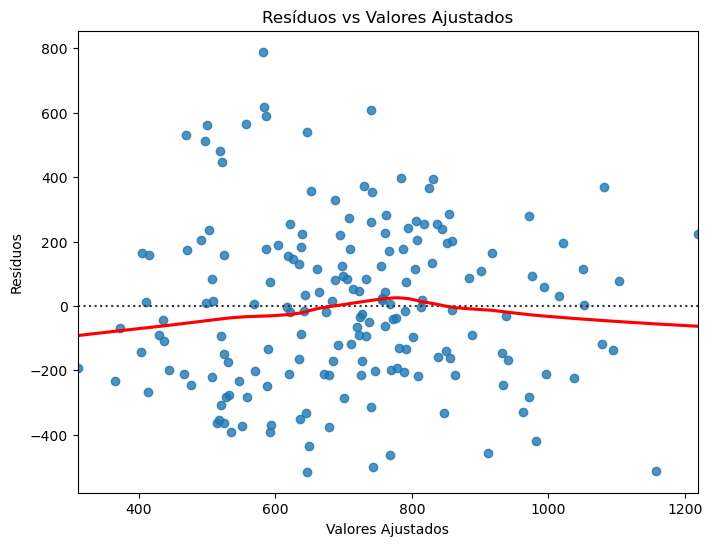

In [56]:
# Gráfico de resíduos vs ajustados - Modelo não-espacial
plt.figure(figsize=(8,6))
sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.show()

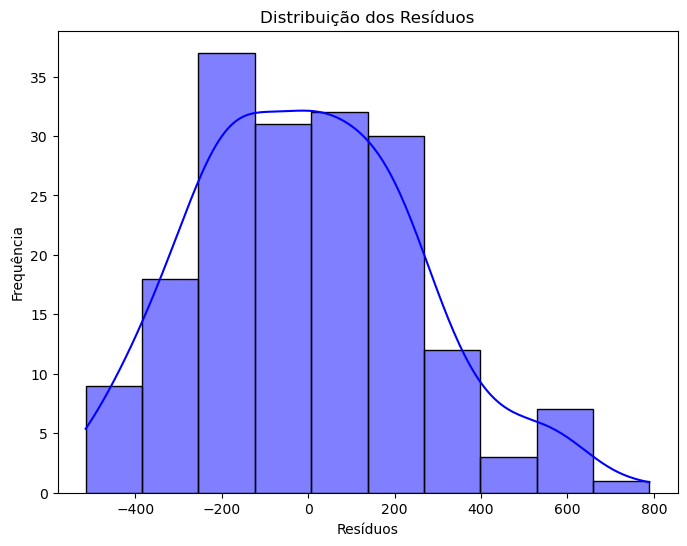

In [57]:
# Histograma dos resíduos
plt.figure(figsize=(8,6))
sns.histplot(results.resid, kde=True, color='blue')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

In [58]:
import scipy.stats as stats

# Teste de normalidade dos resíduos (Shapiro-Wilk)
shapiro_test = stats.shapiro(results.resid)
print(f"Teste de Normalidade (Shapiro-Wilk): p-valor = {shapiro_test.pvalue}")

# Indicação de que os resíduos são normais. No entanto, valor "no limite" do p-valor, indicando que podem existir problemas na especificação "simples" do modelo

Teste de Normalidade (Shapiro-Wilk): p-valor = 0.059031949783062046


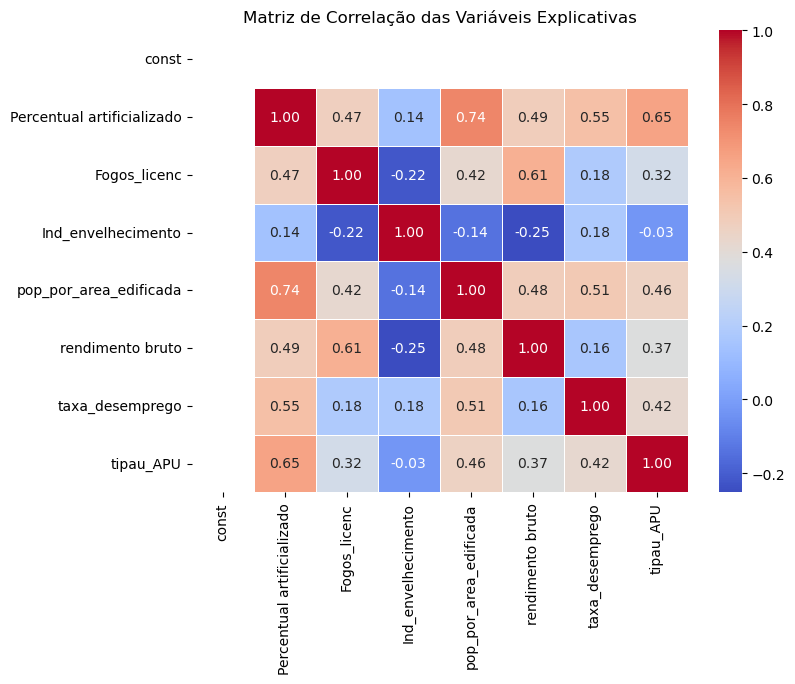

In [59]:
# Teste de multicolinearidade (Correlação entre variáveis explicativas)
corr_matrix = df_X_modelo_nao_espacial.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis Explicativas')
plt.show()

# Indícios de multicolinearidade entre algumas das variáveis - fogos_licenc e rendimento bruto, percentual artificializado e pop_por_area_edificada, e percentual artificializado e tipau_APU, etc

### Modelos espaciais

Nossas análises anteriores pareceram indicar a existência de componentes espaciais à heterogeneidade das variáveis estudadas - tanto da variável target (Preço mediano do m2 dos imóveis transacionados) quanto nas variáveis explicativas. Pudemos verificar a concentração de pontos de preços relativos altos e baixos, com clusters de Freguesias com valores altos agrupadas junto a outras Freguesias com valores altos, por exemplo. Mais: a literatura (e o senso-comum) indicam-nos que o valor dos imóveis (variável dependente) em uma região é também explicado pelo valor dos imóveis nas regiões vizinhas. Portanto, nosso modelo econométrico espacial deverá levar em conta o Spatial Lag.

Deveremos considerar, ainda, a possibilidade de dependência espacial nos resíduos do modelo. Por mais que controlemos as variáveis já incluídas no modelo, há uma infinidade de características locais e regionais não-captadas (muitas delas subjetivas) que poderiam explicar as diferenças nos preços. Portanto é necessário verificar, ainda, a existência ou não de dependência espacial nos resíduos do modelo.

In [60]:
# Obter os resíduos da regressão
residuos = results.resid

# Matriz de vizinhanças e pesos espaciais
w_queen_shape_CAOP_Freguesias

# Cálculo do índice de Moran para os resíduos da regressão
moran_residuos_ols = Moran(residuos, w_queen_shape_CAOP_Freguesias)

# Exibindo o índice de Moran
print(f"Índice de Moran: {moran_residuos_ols.I}")
print(f"Valor p: {moran_residuos_ols.p_sim}")

Índice de Moran: 0.4567135307022057
Valor p: 0.001


O baixo p-valor indica-nos a existência de correlação espacial entre os termos de erro - e, portanto, a necessidade de inclusão de um lambda != de 0. No entanto, é necessário ainda verificar os valores de phi e de lambda através de testes de multiplicadores lagrangeanos

In [61]:
# aplicar LM-Lag para testar rho e LM-Error para testar os resíduos

from spreg.diagnostics_sp import LMtests
from spreg import OLS

# Correr OLS e realizar testes de multiplicadores lagrangeanos
ols_spreg = OLS(df_y_modelo_nao_espacial, df_X_modelo_nao_espacial)
lms = LMtests(ols_spreg, w_queen_shape_CAOP_Freguesias)

In [62]:
estatistica, p_valor = round(lms.rlme[0],4), round(lms.rlme[1],4)
print("Resultados para a estatística do teste RLME (resíduos): {}".format(estatistica))
print("Resultados para o p-valor do teste RLME (resíduos): {}\n".format(p_valor))

estatistica, p_valor = round(lms.rlml[0],4), round(lms.rlml[1],4)
print("Resultados para a estatística do teste RLML (lag): {}".format(estatistica))
print("Resultados para o p-valor do teste RLML (lag): {}\n".format(p_valor))

Resultados para a estatística do teste RLME (resíduos): 0.9265
Resultados para o p-valor do teste RLME (resíduos): 0.3358

Resultados para a estatística do teste RLML (lag): 35.7402
Resultados para o p-valor do teste RLML (lag): 0.0



Não temos evidência suficiente, via Lagrange Multiplier tests, de dependência espacial relacionada aos resíduos. Por outro lado, há evidências estatisticamente significantes da existência de autocorrelação espacial nos valores da variável da dependente. Portanto, deveremos ajustar nossos dados a um modelo SDM (Spatial Durbin Model), considerando também possíveis efeitos de dependência espacial nas variáveis (X) e efeitos de Spillover Global.

In [71]:
from spreg import ML_Lag

# Rodar modelo SDM
sdm_spreg = ML_Lag(df_y_modelo_nao_espacial, 
             df_X_modelo_nao_espacial, 
             w_queen_shape_CAOP_Freguesias, 
             slx_lags=1)

print(sdm_spreg.title)
sdm_spreg.output

MAXIMUM LIKELIHOOD SPATIAL LAG WITH SLX - SPATIAL DURBIN MODEL (METHOD = FULL)


var_names coefficients     std_err    zt_stat      prob
0                       CONSTANT  -161.229735  233.621146  -0.690133   0.49011
1     Percentual artificializado   -22.034576  189.099808  -0.116524  0.907238
2                   Fogos_licenc     0.465142    0.694519   0.669732  0.503029
3             Ind_envelhecimento     0.081498    0.360012   0.226376  0.820909
4         pop_por_area_edificada     2.011851    1.730265   1.162741  0.244935
5               rendimento bruto     0.005658    0.007199   0.785914  0.431918
6                taxa_desemprego     5.703932   11.658764    0.48924  0.624672
7                      tipau_APU     1.728311    38.94776   0.044375  0.964605
8   W_Percentual artificializado  -362.518655  418.869662  -0.865469  0.386781
9                 W_Fogos_licenc     1.465856    1.654698   0.885875  0.375685
10          W_Ind_envelhecimento      0.03429    0.774175   0.044292  0.964672
11      W_pop_por_area_edificada    -3.533927    3.738175  -0.945362  0.344474
12            W_rendimento bruto     0.007756    0.012775   0.607106  0.543781
13             W_taxa_desemprego    16.901658   17.934068   0.942433  0.345971
14                   W_tipau_APU    164.38776    80.38659   2.044965  0.040858
15          W_PreçoInputadoQueen     0.717706    0.058723  12.221982       0.0

In [64]:
# Correr modelo SAR
sar_model = ML_Lag(df_y_modelo_nao_espacial, 
            df_X_modelo_nao_espacial, 
            w_queen_shape_CAOP_Freguesias, 
            slx_lags=0)

print(sar_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :PreçoInputadoQueen                Number of Observations:         180
Mean dependent var  :    708.0484                Number of Variables   :           9
S.D. dependent var  :    310.8354                Degrees of Freedom    :         171
Pseudo R-squared    :      0.7109
Spatial Pseudo R-squared:  0.4647
Log likelihood      :  -1193.5339
Sigma-square ML     :  28550.9798                Akaike info criterion :    2405.068
S.E of regression   :    168.9704                Schwarz criterion     :    2433.804

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------

In [65]:
from spreg import likratiotest

# Verificar verossimilhança
lr = likratiotest(sar_model, sdm_spreg)

print("Likelihood Ratio Test: {0:.4f}       df: {1}        p-value: {2:.8f}".format(lr["likr"],lr["df"],lr["p-value"]))

Likelihood Ratio Test: 9.8111       df: 7        p-value: 0.19953494


Com um p-valor de aproximadamente 0,2, não rejeitamos a hipótese nula de que os modelos não apresentam diferenças. Assim sendo, podemos concluir que o parâmetro theta é 0, ou muito próximo de 0, e por isso devemos optar pela utilização de um modelo SAR.